# PCA visualization
Using output files from SmartPCA or FlashPCA
SmartPCA has region info included, no need to merge with meta data

In [1]:
from bokeh.palettes import Dark2_5 as palette
import itertools
from bokeh.plotting import output_file, save

In [2]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from bokeh.palettes import Spectral4
from bokeh.core.enums import MarkerType
from bokeh.plotting import figure, show
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27
rcParams['svg.fonttype'] = 'none'
%matplotlib notebook
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
from myutils import colors, colors2, markers, markers2
import numpy as np

In [4]:
markers

{'Sad': 'circle',
 'Amr': 'dot',
 'San': 'star',
 'Dhm': 'x',
 'Mhw': 'circle',
 'Haj': 'x',
 'Hdr': 'circle',
 'Shb': 'x',
 'Ibb': 'circle',
 'Tiz': 'x',
 'Jwf': 'circle',
 'Mrb': 'x',
 'Byd': 'star',
 'Dal': 'circle',
 'Lahj': 'x',
 'Abyn': 'dot',
 'Rsa': 'circle'}

### Loading PCA results

PCA was done for the merged dataset HGDP+ Yemen169.
Performed with FlashPCA, which gives up to 10 PCs.
Annoyingly, the Ids were of different format to the ones in the meta data, so had to fix that:

urn:wtsi:402769_H09_3577STDY6068568 -> 3577STDY6068568


In [5]:
## global variables
yregions = ('Sad', 'Amr', 'San', 'Dhm', 'Mhw', 'Haj', 'Hdr', 'Shb', 'Ibb', 'Tiz', 'Jwf', 'Mrb', 'Byd', 'Dal', 'Lahj', 'Abyn', 'Rsa')

def format(line):
    fields = line.split()
    iid = fields[0]
    if iid.startswith: iid = iid[-15:]
    return [iid] + list(map(float, fields[1:-1])) + fields[-1:]

def getPCAdata(geoPCA=3000, dataset='HO', mind='0.3', geno='0.2'):
    if geoPCA is not None: # 0 stands for Yemen only
        addon=geoPCA//1000
    else: addon=""
    base = f"{dataset}_mind{mind}_geno_{geno}"
    wdir = f"../AdmixTools_{base}"
    pcafile = f'{wdir}/yemen_reich{base}.LD.QC{addon}.pcs.txt' ## careful, slight inconsist. naming convention HGDP/Reich
    print(f"Reading from PCA file {pcafile}")

    df = pd.DataFrame([format(line) for line in open(pcafile) if not line.strip().startswith('#eigvals')])
    df.columns = ['FID1'] + [f'PC{i}' for i in range(1,11)] + ['Region']
    ddf = df.set_index('FID1')
    return ddf

In [6]:
from bokeh.core.enums import MarkerType
#from bokeh import 
def plotPCA(ddf, regions, unmuted, width=1400, height=1600, saveFig=None, title="", nonYemenMarkers=['triangle'], PCs=['PC1','PC2']):
    regions = unmuted  + list(set(regions).difference(unmuted))
    if saveFig and saveFig.endswith(".html"):
        output_file(filename=saveFig, title=title)
    p = figure(width=width, height=height)

    x = ddf[PCs].values
    y = ddf['Region'].values

    bokehColors = itertools.cycle(palette)
    bokehMarkers = itertools.cycle(nonYemenMarkers)
    scatter={}

    for region in regions:
        #print('Region:', region)
        if region in yregions: 
            alpha = 1
        else:
            alpha = 0.5
        scatter[region] = p.scatter(x[y==region].T[0], x[y==region].T[1], 
            color=colors.get(region, next(bokehColors)), 
            marker=markers2.get(region, next(bokehMarkers)),
            #marker = marker,
            size=7,
            alpha=alpha, muted_color='grey', muted_alpha = 0.1, legend_label=region
        )
        if not region in unmuted:
            scatter[region].muted = True            
    p.legend.location = "top_left"
    p.legend.click_policy = 'mute'
    show(p)
    if saveFig: 
        if saveFig.endswith('.html'):
            result = save(p)
            print(result)
        elif saveFig.endswith('.svg'):
            pass
            #export_svg(p, filename=saveFig)
    return p
#        else:
#            
#            p.savefig(saveFig)


In [7]:
def getRegions(pcaDF, dataset, geoPCA=None, ancient=False, contemp=True):
    if geoPCA:
        # contemporary
        regions = [line.strip() for line in open(f"../Data/popfile_{dataset}_{geoPCA}.txt")]
    else:  
        if contemp:
            regions = yregions + list(zip(*Counter(pcaDF.Region).most_common(40)))[0]
        if ancient:
            ancientAsianPops = ['Turkmenistan_Gonur_BA_1', 'Iran_C_TepeHissar', 'Israel_MLBA', 'Turkmenistan_Gonur_BA_1_lc', 'Uzbekistan_SappaliTepe_BA', 'Israel_C', 'Turkey_N', 'India_RoopkundB', 'India_RoopkundA', 'Taiwan_Hanben_IA', 'Pakistan_Katelai_IA', 'Pakistan_Loebanr_IA', 'Mongolia_EIA_Sagly_4', 'Pakistan_Udegram_IA', 'Jordan_LBA', 'Mongolia_EIA_SlabGrave_1', 'Turkmenistan_C_Geoksyur', 'Kyrgyzstan_TianShan_Hun.SG', 'Mongolia_LBA_Khovsgol_6', 'Turkey_Alalakh_MLBA', 'Turkey_Arslantepe_LateC', 'Syria_Ebla_EMBA', 'Turkey_Ikiztepe_LateC', 'China_SEastAsia_Coastal_LN']
            regions = yregions + tuple(ancientAsianPops)
        
    return list(regions)


In [8]:
ymarkers = set([markers2[yr] for yr in yregions])
nonYemenMarkers = [marker for marker in MarkerType if not marker in ymarkers and not marker in ['star', 'dot']]


## Context: HO + OOA (PZ) + East Africa (LP)
selected populations, see popfile in datadir

In [9]:
## getting pop info from ind file
datadir = '../AdmixTools_Yemen_HO_OOA_geno05/'
ind = pd.read_csv(f'{datadir}yemen_ooa_ee.LD.ind', delim_whitespace=True, header=None)
pcafile = f'{datadir}/yemen_ooa_ee.LD.pcs.txt'
regions = [line.strip() for line in open(f'{datadir}/popfile.txt')]
df = pd.DataFrame([format(line) for line in open(pcafile) if not line.strip().startswith('#eigvals')])
df.columns = ['FID1'] + [f'PC{i}' for i in range(1,11)] + ['Region']
pcaDF = df.set_index('FID1')

In [10]:
plot = plotPCA(pcaDF, regions, regions, width=2400, height=1200, saveFig=f"../Results/ho_ooa_ee_PCA12.html", nonYemenMarkers=nonYemenMarkers)

/home/ahenschel/Dropbox/Yemen/YemenGenomeAnalysis/Results/ho_ooa_ee_PCA12.html


### Principal components 1 and 3

In [21]:
plot = plotPCA(pcaDF, regions, regions, width=1400, height=1200, saveFig=f"../Results/ho_ooa_ee_PCA13.html", nonYemenMarkers=nonYemenMarkers, PCs=['PC1','PC3'])

/home/ahenschel/Dropbox/Yemen/YemenGenomeAnalysis/Results/ho_ooa_ee_PCA13.html


### Principal components 2 and 3

In [23]:
plot = plotPCA(pcaDF, regions, regions, width=1400, height=1200, saveFig=f"../Results/ho_ooa_ee_PCA34.html", nonYemenMarkers=nonYemenMarkers, PCs=['PC3','PC4'])

/home/ahenschel/Dropbox/Yemen/YemenGenomeAnalysis/Results/ho_ooa_ee_PCA34.html


## Ancient - 1240K

## Ancient - 1240K

In [11]:
dataset = "1240K"
pcaDF = getPCAdata(geoPCA=None , dataset = dataset, mind=0.5, geno=0.5) ## allow more missingness, so to avoid empty populations
regions = getRegions(pcaDF, dataset, ancient=True)


Reading from PCA file ../AdmixTools_1240K_mind0.5_geno_0.5/yemen_reich1240K_mind0.5_geno_0.5.LD.QC.pcs.txt


In [12]:
#plotPCA(pcaDF, regions, regions, width=1400, height=1200, saveFig=f"../Results/full_{dataset}_ancient_PCA.html", nonYemenMarkers=nonYemenMarkers)
plot = plotPCA(pcaDF, regions, regions, width=1400, height=1200, saveFig=f"../Results/full_{dataset}_ancient_PCA.svg", nonYemenMarkers=nonYemenMarkers)

In [327]:
export_svg(plot, filename="bokehPlot_a1240K.svg")

['bokehPlot_a1240K.svg']

## Ancient - Human Origins

In [10]:
dataset = "HO"
pcaDF = getPCAdata(geoPCA=None , dataset = dataset)
regions = getRegions(pcaDF, dataset, ancient=True)
plotPCA(pcaDF, regions, regions, width=1400, height=1200, saveFig=f"../Results/full_{dataset}_ancient_PCA.html", nonYemenMarkers=nonYemenMarkers)

Reading from PCA file ../AdmixTools_HO_mind0.3_geno_0.2/yemen_reichHO_mind0.3_geno_0.2.LD.QC.pcs.txt


/home/ahenschel/Dropbox/Yemen/YemenGenomeAnalysis/Results/full_HO_ancient_PCA.html


Figure(id='1003', ...)

## Comprehensive World PCA
PCA was run on complete Reich Human Origin dataset using smartPCA, excluding ancient populations (for spanning the principle components). Plot is interactive.

In [11]:
Counter(pcaDF.Region).most_common()[40:]
whiteL = "Saudi BedouinA BedouinB.SDG Brahui Mozabite Kalash.SDG BedouinA.SDG Egyptian Yemeni_Desert2 Yemeni_Highlands Yemeni_Northwest Jew_Yemenite  Lebanese Syrian Turkey_Arslantepe_LateC Mozabite.SDG Jordanian Jew_Libyan Tunisian Algerian Iranian_Bandari Afar.WGA Libya Eritrea Jew_Ethiopian".split()
whiteL = "Saudi BedouinA BedouinB.SDG Mozabite Egyptian Jew_Yemenite Lebanese Syrian Mozabite.SDG Jordanian Tunisian Algerian Iranian_Bandari".split()

blackL = "Fin.SG ESN.SG Tibetan Russian French Han Spanish JPT.SG Sweden_Viking.SG".split()

In [12]:
whiteL

['Saudi',
 'BedouinA',
 'BedouinB.SDG',
 'Mozabite',
 'Egyptian',
 'Jew_Yemenite',
 'Lebanese',
 'Syrian',
 'Mozabite.SDG',
 'Jordanian',
 'Tunisian',
 'Algerian',
 'Iranian_Bandari']

In [13]:
Counter(pcaDF.Region)

Counter({'Malawi_Yao': 9,
         'Malawi_Chewa': 11,
         'Malawi_Ngoni': 4,
         'Malawi_Tumbuka': 10,
         'Karachai': 12,
         'Adygei': 31,
         'Altaian_Chelkan': 8,
         'Tubalar': 27,
         'Altaian': 24,
         'Nivh': 10,
         'Evenk_FarEast': 5,
         'Negidal': 3,
         'Nanai': 10,
         'Armenian_Hemsheni': 8,
         'Azeri': 17,
         'Bashkir': 53,
         'Buryat': 37,
         'Khamnegan': 10,
         'Circassian': 9,
         'Tabasaran': 10,
         'Darginian': 8,
         'Kubachinian': 6,
         'Lak': 10,
         'Avar': 8,
         'Kaitag': 8,
         'Evenk_Transbaikal': 8,
         'Ezid': 8,
         'Gagauz': 9,
         'Georgian': 23,
         'Ingushian': 10,
         'Kabardinian': 9,
         'Karelian': 15,
         'Veps': 10,
         'Abazin': 8,
         'Shor_Khakassia': 6,
         'Khakass': 15,
         'Khakass_Kachin': 8,
         'Karakalpak': 14,
         'Kurd': 8,
         'Kazakh':

In [14]:
dataset = "HO"
pcaDF = getPCAdata(geoPCA=None , dataset = dataset)
regions = getRegions(pcaDF, dataset)
regions += whiteL
regions = [r for r in regions if not r in blackL]
unmuted = "Turkish Palestinian Iranian Saudi BedouinA BedouinB.SDG Mozabite Lebanese Syrian Jordanian Tunisian Algerian Iranian_Bandari".split()

Reading from PCA file ../AdmixTools_HO_mind0.3_geno_0.2/yemen_reichHO_mind0.3_geno_0.2.LD.QC.pcs.txt


In [56]:
plotPCA(pcaDF, regions, unmuted+list(yregions), width=1800, height=2000, saveFig=f"../Results/full_{dataset}_PCA.html", nonYemenMarkers=nonYemenMarkers)

/home/ahenschel/Dropbox/Yemen/YemenGenomeAnalysis/Results/full_HO_PCA.html


Figure(id='9561', ...)

In [228]:
plotPCA(pcaDF, regions, regions, width=1800, height=2000, saveFig=f"../Results/full_{dataset}_PCA.html", nonYemenMarkers=nonYemenMarkers, PCs=['PC3', 'PC4'])

/mnt/Drive1/ahenschel/SambaShare/YemenGenomeAnalysis/Results/full_HO_PCA.html


Figure(id='429394', ...)

## Regional PCA - 4000k (Human Origins)
The below PCA plots where calculated independently on selected populations (others might appear, but the Principle Components are only derived from locations selected by geographic (Haversine) distance.
Here including populations within 4000 km. Populations within 2000km are active, others are greyed out initially. Note that some populations that are >2000k away are closer than some that are <2000k

In [57]:
geoPCA = 4000
dataset ="HO"
pcaDF = getPCAdata(geoPCA , dataset = dataset)
regions = getRegions(pcaDF, dataset, geoPCA)
regionsUnmuted = [line.strip() for line in open(f"../Data/popfile_{dataset}_{2000}.txt")]
plotPCA(pcaDF, regions, regionsUnmuted, width=1400, height=4000, saveFig=f"../Results/region{geoPCA}_PCA.html", nonYemenMarkers=nonYemenMarkers)

Reading from PCA file ../AdmixTools_HO_mind0.3_geno_0.2/yemen_reichHO_mind0.3_geno_0.2.LD.QC4.pcs.txt


/home/ahenschel/Dropbox/Yemen/YemenGenomeAnalysis/Results/region4000_PCA.html


Figure(id='19201', ...)

## Regional PCA - 3000k (Human Origins)
including populations within 3000 km. Populations within 2000km are active, others are greyed out initially. Again note that some populations that are >2000k away are closer than some that are <2000k

In [229]:
geoPCA = 3000
pcaDF = getPCAdata(geoPCA , dataset = "HO")
regions = getRegions(pcaDF, dataset, geoPCA)
regions = regions + whiteL
regionsUnmuted = [line.strip() for line in open(f"../Data/popfile_{dataset}_{2000}.txt")]
plotPCA(pcaDF, regions, regions, width=3000, height=1800, saveFig=f"../Results/region{geoPCA}_PCA.html", nonYemenMarkers=nonYemenMarkers)

/mnt/Drive1/ahenschel/SambaShare/YemenGenomeAnalysis/Results/region3000_PCA.html


Figure(id='445785', ...)

## Regional PCA - 2000k (Human Origins)
including populations within 2000 km. 

In [230]:
geoPCA = 2000
pcaDF = getPCAdata(geoPCA, dataset = "HO")
regions = getRegions(pcaDF, dataset, geoPCA)
#regionsUnmuted = [line.strip() for line in open(f"../Data/popfile_{dataset}_{2000}.txt")]
plotPCA(pcaDF, regions, regions, width=3000, height=1400, saveFig=f"../Results/region{geoPCA}_PCA.html", nonYemenMarkers=nonYemenMarkers)

/mnt/Drive1/ahenschel/SambaShare/YemenGenomeAnalysis/Results/region2000_PCA.html


Figure(id='483900', ...)

## Regional PCA - 1000k (Human Origins)
including populations within 1000 km. 

In [27]:
geoPCA = 1000
pcaDF = getPCAdata(geoPCA, dataset = "HO")
regions = getRegions(pcaDF, dataset, geoPCA)
regions += whiteL
#regionsUnmuted = [line.strip() for line in open(f"../Data/popfile_{dataset}_{2000}.txt")]
plotPCA(pcaDF, regions, regions, width=3000, height=1400, saveFig=f"../Results/region{geoPCA}_PCA.html", nonYemenMarkers=nonYemenMarkers)

/home/ahenschel/Dropbox/Yemen/YemenGenomeAnalysis/Results/region1000_PCA.html


Figure(id='19200', ...)

In [339]:
## population selection
## Eg. only ancient from Asia, at least 10 samples
## readReich like in preparePopsF3Adm.py (incl. regions, ie. continents)

#reich = readReich('1240K', allRegions=True)
#lu = lambda p: list(r2[r2.Group_Label==p]['Region'])[0] ## lookup Group_Label -> continent
#ancient10 = [(pop,lu(pop)) for pop, count in Counter(reich.Group_Label).items() if count>10]
#[pop for pop, cont in ancient10 if cont=='AS']


## Yemen only
While other regions are projected on PC1 and PC2, those eigenvectors were calculated only with Yemen samples:
`/Dropbox/Yemen/YemenGenomeAnalysis/AdmixTools_HO_mind0.3_geno_0.2` `smartpca -p param_pca_0000.txt`
and `../Data/popfile_HO_0000.txt` only contains Yemen populations.

Number of samples after outlier removal: 136

In [16]:
pcafile = "../AdmixTools_HO_mind0.3_geno_0.2/yemen_reichHO_mind0.3_geno_0.2.LD.QC0.pcs.txt"
geoPCA='0000'
ddf = getPCAdata(geoPCA=0, dataset = "HO")
#getRegions(pcaDF, dataset, geoPCA)
# interactive plot
regions = list(yregions)
plotPCA(ddf, regions, regions, width=3000, height=1400, saveFig=f"../Results/yemenOnly_PCA.html", nonYemenMarkers=nonYemenMarkers)


Reading from PCA file ../AdmixTools_HO_mind0.3_geno_0.2/yemen_reichHO_mind0.3_geno_0.2.LD.QC0.pcs.txt


/home/ahenschel/Dropbox/Yemen/YemenGenomeAnalysis/Results/yemenOnly_PCA.html


Figure(id='8318', ...)

In [18]:
markers2
markers3 = {'Sad': 'o', 'Amr': '*', 'San': 'D', 'Dhm': 'x', 'Mhw': 'o', 'Haj': 'x', 'Hdr': 'o', 'Shb': 'x', 'Ibb': 'o', 'Tiz': 'x', 'Jwf': 'o', 'Mrb': 'x', 'Byd': 'D', 'Dal': 'o', 'Lahj': 'x', 'Abyn': '*', 'Rsa': 'o', 'HGDP': 'plus', 'Subsaharian_Africa': 'plus', 'America': 'plus', 'Asia': 'plus', 'Europe': 'plus', 'Middle_Est': 'plus', 'North_Africa': 'plus', 'Oceania': 'plus'}
for k,v in colors.items():
    if v=='yellow':
        colors[k]=='darkkhaki'

In [19]:
markers3

{'Sad': 'o',
 'Amr': '*',
 'San': 'D',
 'Dhm': 'x',
 'Mhw': 'o',
 'Haj': 'x',
 'Hdr': 'o',
 'Shb': 'x',
 'Ibb': 'o',
 'Tiz': 'x',
 'Jwf': 'o',
 'Mrb': 'x',
 'Byd': 'D',
 'Dal': 'o',
 'Lahj': 'x',
 'Abyn': '*',
 'Rsa': 'o',
 'HGDP': 'plus',
 'Subsaharian_Africa': 'plus',
 'America': 'plus',
 'Asia': 'plus',
 'Europe': 'plus',
 'Middle_Est': 'plus',
 'North_Africa': 'plus',
 'Oceania': 'plus'}

### Plotting non-interactively
Plain matplotlib plot, so to save as svg

Reading from PCA file ../AdmixTools_HO_mind0.3_geno_0.2/yemen_reichHO_mind0.3_geno_0.2.LD.QC0.pcs.txt


<IPython.core.display.Javascript object>


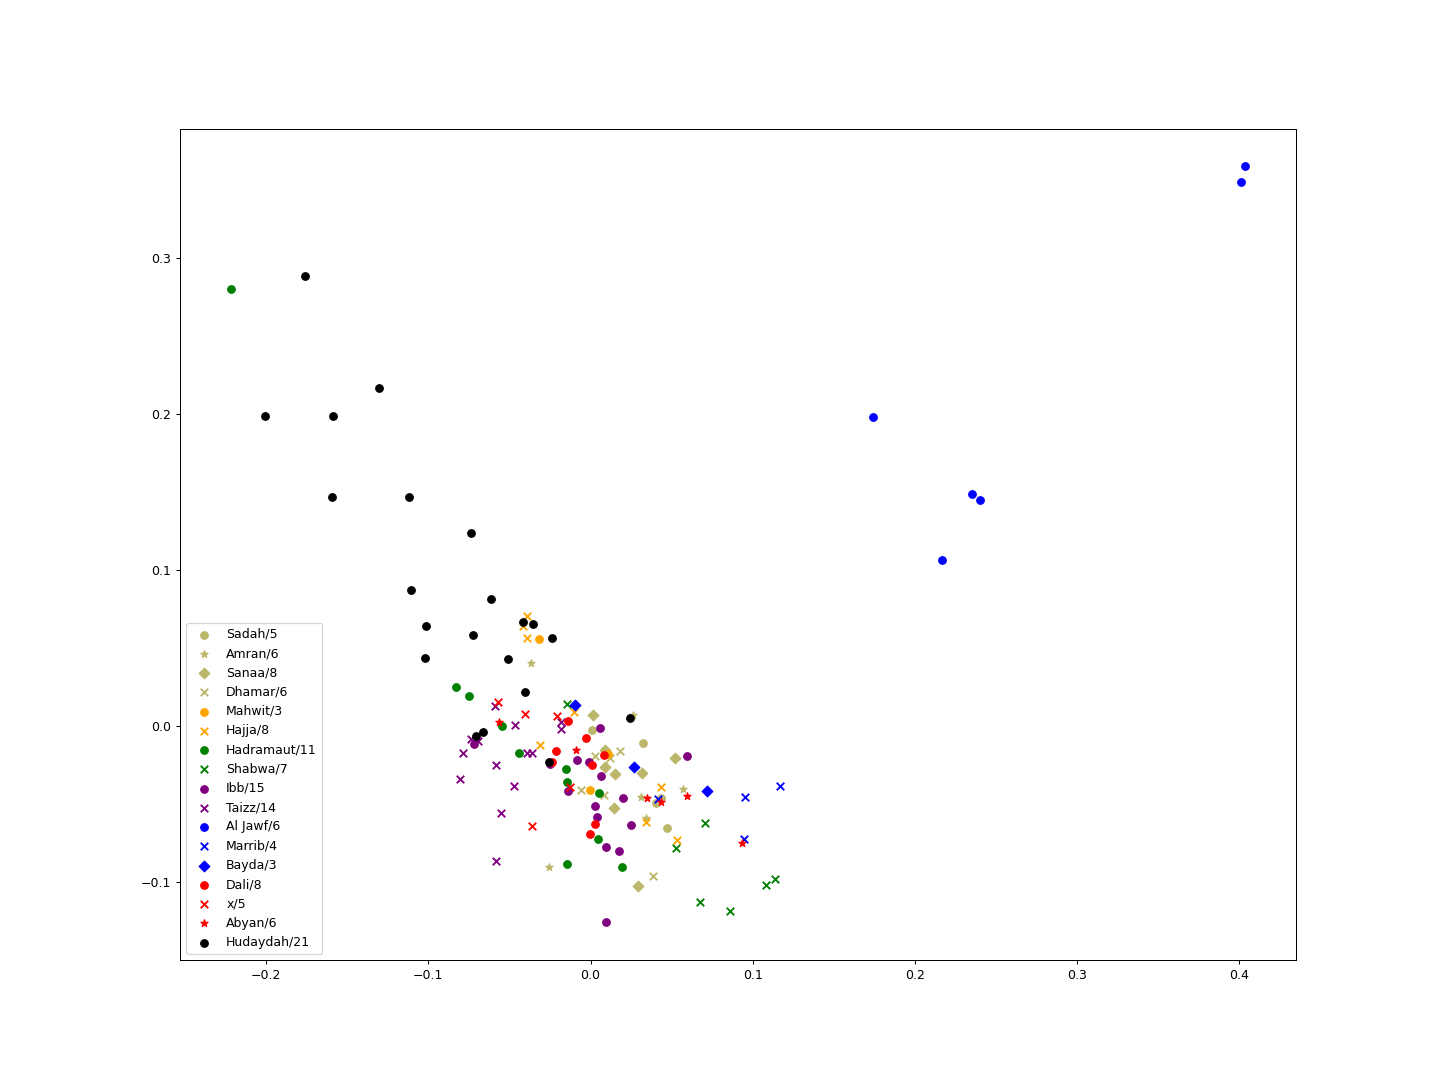

In [20]:
geoPCA='0000'
ddf = getPCAdata(geoPCA=0, dataset = "HO")
fig, ax = plt.subplots(figsize=(16,12))
fullGovNames = {'Sad': 'Sadah', 'Amr': 'Amran', 'San': 'Sanaa', 'Dhm': 'Dhamar', 'Mhw': 'Mahwit', 'Haj': 'Hajja', 'Hdr': 'Hadramaut', 'Shb': 'Shabwa', 'Ibb': 'Ibb', 'Tiz': 'Taizz', 'Jwf': 'Al Jawf', 'Mrb': 'Marrib', 'Byd': 'Bayda', 'Dal': 'Dali', 'Lahj': 'x', 'Abyn': 'Abyan', 'Rsa': 'Hudaydah'}
for pop in yregions:
    Y = ddf[ddf.Region==pop]
    if Y.shape[0] > 1:   
        color = colors.get(pop, 'grey')
        if color == 'yellow': color = 'darkkhaki'
        marker = markers3[pop] 
        fullGovName = fullGovNames[pop]
        ax.scatter(Y.PC1, Y.PC2, c=color, label=f'{fullGovName}/{Y.shape[0]}', marker=marker)
#for distr in 'Mrb Rsa Ibb Sad Hdr Lahj'.split(): #yregions:
#    Y = ddf[ddf.Region==pop]
#    if Y.shape[0] > 1:
#        cmap = next(gradients)        
#        sns.kdeplot(data=Y, x='PC1', y='PC2', cmap = cmap, ax=ax, levels=7)
ax.legend()
plt.savefig("popstratYemen.svg")
plt.savefig("popstratYemen.pdf")
cmd = """grep "^REMOVED outlier" smartpca_0000_HO.log | cut -f4 -d':' |sort |uniq -c |sort -n -r
     14  Rsa      9  Hdr      4  Jwf      2  Shb      2  San      2  Ibb"""

# PCA with Kernel density maps

In addition to normal PCA scatter plots, we draw Kernel density estimation maps, using seaborn.

## KDE plots for four Yemen populations 
Hadramout, Ibb, Tizz and Rsa clearly have distinctive PCs. PCA performed on sampels within 1000k. Those four regions have all at least 12 samples It also clearly shows a different level of diversity. While Tizz is very compact, Hadramaut (known for active seafarers, spice trade) stronger differences.

In [15]:
import matplotlib.colors as mcolors


<IPython.core.display.Javascript object>


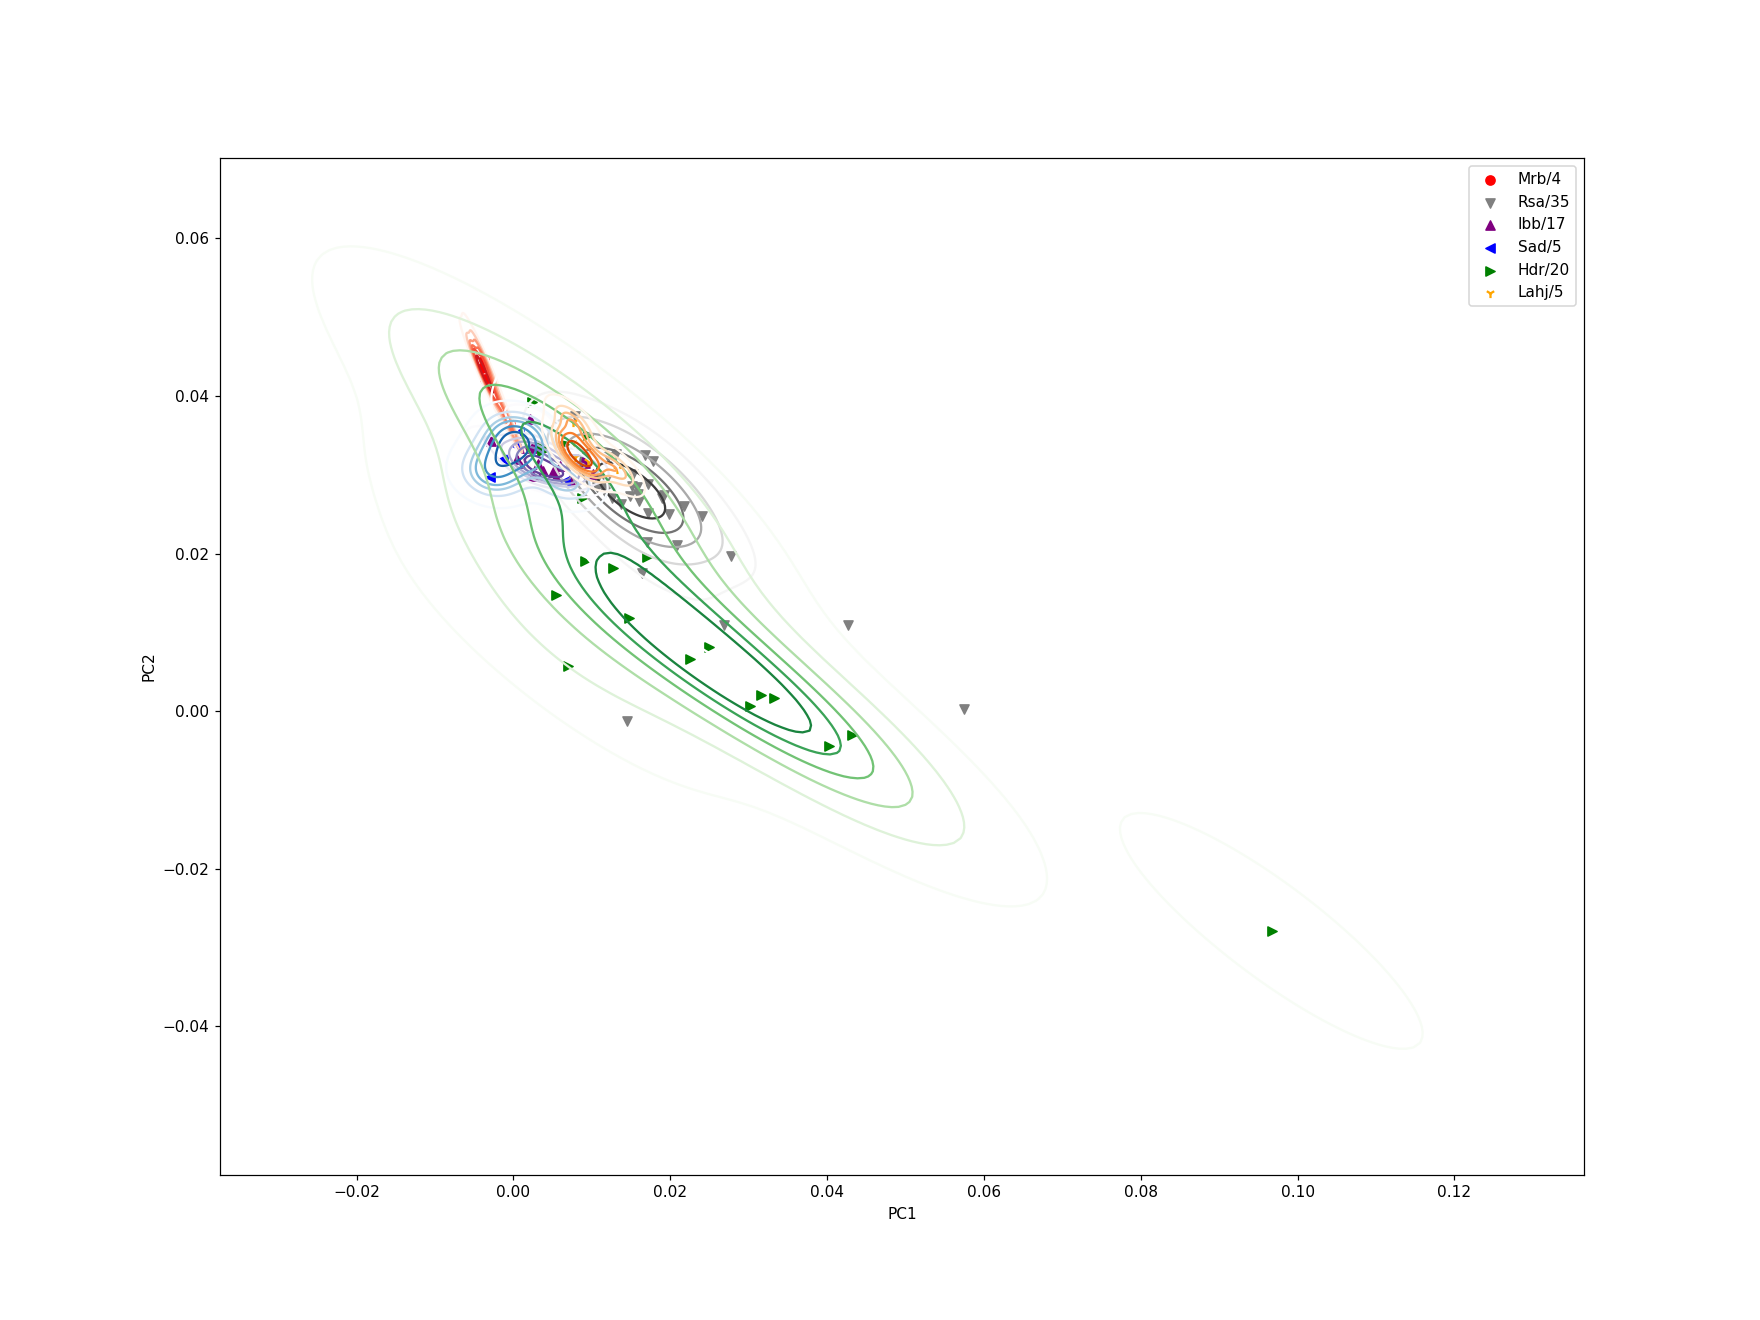

In [16]:

import seaborn as sns
import matplotlib

mplcolors = itertools.cycle(mcolors.CSS4_COLORS.values())
markers = itertools.cycle("ov^<>12348spP*hH+xXDd|")

#ddf = pcaDF ## taking from last pcaDF, make sure this is the correct context (or no context at all)
fig, ax = plt.subplots(figsize=(16,12))
gradients = itertools.cycle([ 'Reds', 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'PuRd',    'RdPu',     'BuPu',       'GnBu', 'PuBu',    'YlGnBu', 'PuBuGn',  'BuGn', 'YlGn'])
gradcols  = itertools.cycle([ 'Red', 'Grey',   'Purple',  'Blue',  'Green',  'Orange',  'fuchsia', 'deeppink', 'royalblue',  'lime', 'orchid',  'olive',  'darkgreen','cyan', 'darkseagreen'])

for pop in 'Mrb Rsa Ibb Sad Hdr Lahj'.split(): #yregions:
    Y = ddf[ddf.Region==pop]
    if Y.shape[0] > 1:
        cmap = next(gradients)        
        sns.kdeplot(data=Y, x='PC1', y='PC2', cmap = cmap, ax=ax, levels=7)
        color=next(gradcols)
        marker=next(markers)
        ax.scatter(Y.PC1, Y.PC2, c=color, label=f'{pop}/{Y.shape[0]}', marker=marker)

ax.legend()
plt.savefig("popstrat6sel.pdf")

In [82]:
#outliers = ['3577STDY6068449', # Hudaydah
#            '3577STDY6068423', '3577STDY6068491', '3577STDY6068456', # Sheba
#           ]

In [17]:
districts = {'Azal': ['Sad', 'Amr', 'San', 'Dhm'], 
             'Tahamh': ['Mhw', 'Haj'], 
             'Hadramaut':['Hdr', 'Shb'], 
             'Aljanad': ['Ibb', 'Tiz'], 
             'Sheba': ['Jwf', 'Mrb', 'Byd'], 
             'Aden': ['Dal', 'Lahj', 'Abyn'], 
             'Hudaydah': ['Rsa']}

<IPython.core.display.Javascript object>


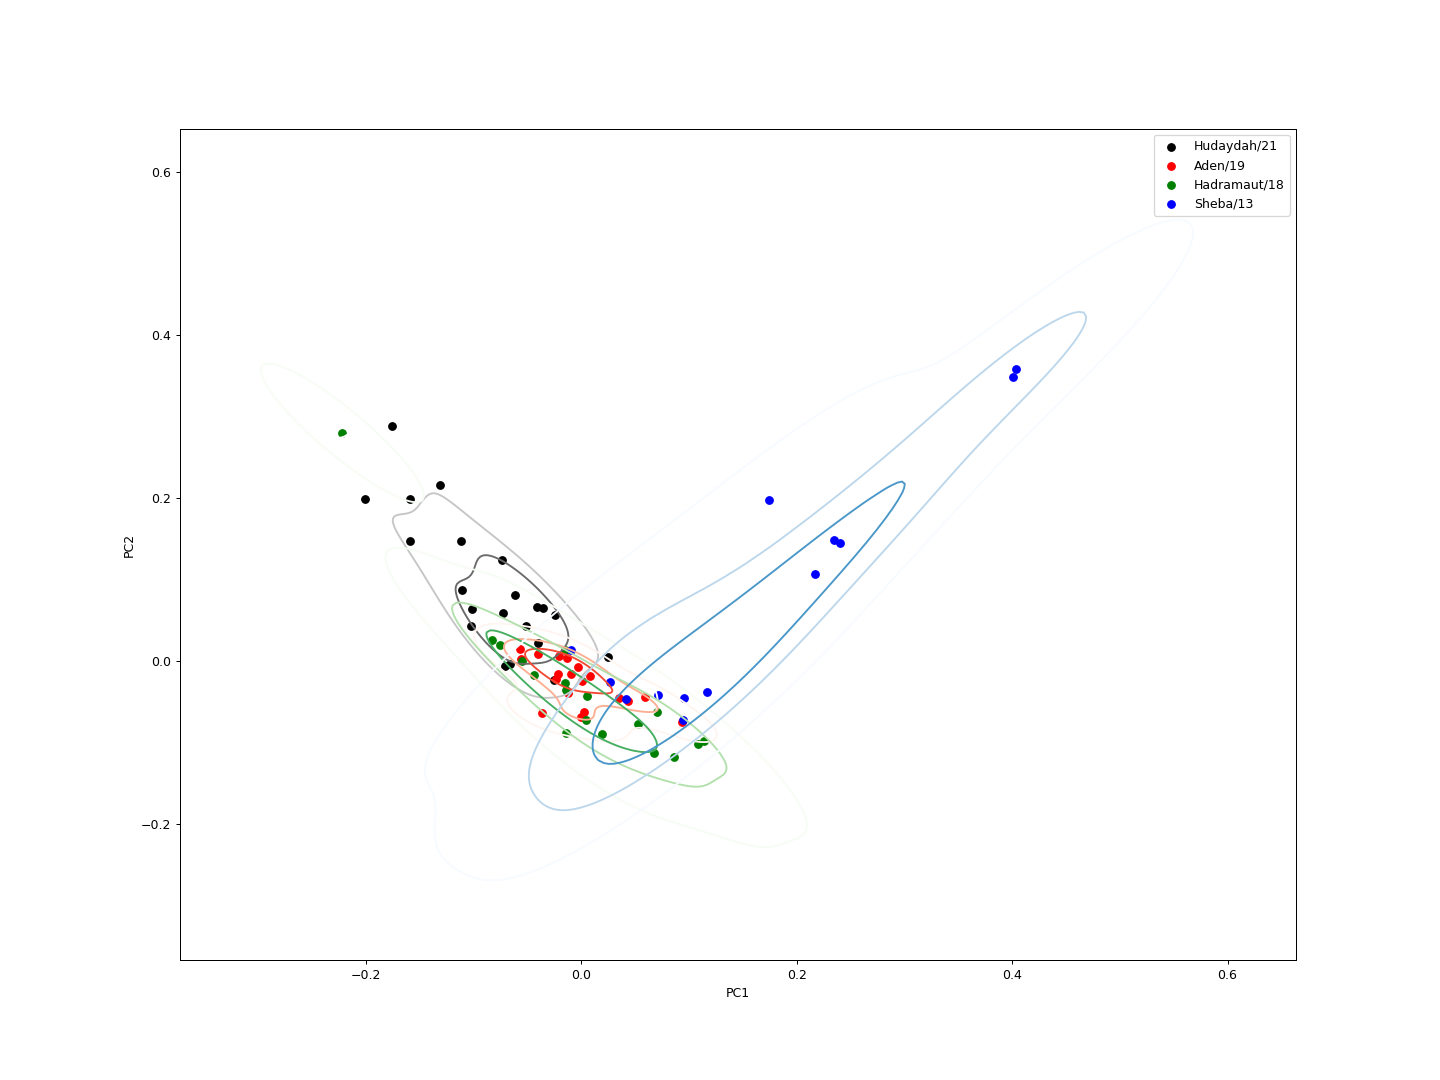

In [25]:
fig, ax = plt.subplots(figsize=(16,12))

selDistricts = 'Hudaydah Aden Hadramaut Sheba'.split()
dcolors = "krgb"
gradients = [ 'Greys', 'Reds', 'Greens', 'Blues'] #, 'Oranges', 'PuRd',    'RdPu',     'BuPu',       'GnBu', 'PuBu',    'YlGnBu', 'PuBuGn',  'BuGn', 'YlGn'])

colorDict = dict(zip(selDistricts, dcolors))
gradientDict = dict(zip(selDistricts, gradients))

for distr in selDistricts:
    Y = ddf[ddf.Region.isin(districts[distr])]
    cmap = gradientDict[distr]
    color = colorDict[distr]
    sns.kdeplot(data=Y, x='PC1', y='PC2', cmap = cmap, ax=ax, levels=4)
    #marker=next(markers)
    ax.scatter(Y.PC1, Y.PC2, c=color, label=f'{distr}/{Y.shape[0]}', marker='o')

ax.legend()
#plt.show()

The above figure shows strong stratification between four selected Yemeni regions: Hadramaut, Ibb, Taizz (Tiz) and Zabid+Al-Hadida (RSA). Although overlaps exist, a clear clustering is apparent.

In [26]:
plt.savefig("yemen4majorDistricts.svg")

In [27]:
!pwd

/home/ahenschel/Dropbox/Yemen/YemenGenomeAnalysis/Notebooks


## Meta analysis with Yemen data from Vyas et al.

<IPython.core.display.Javascript object>


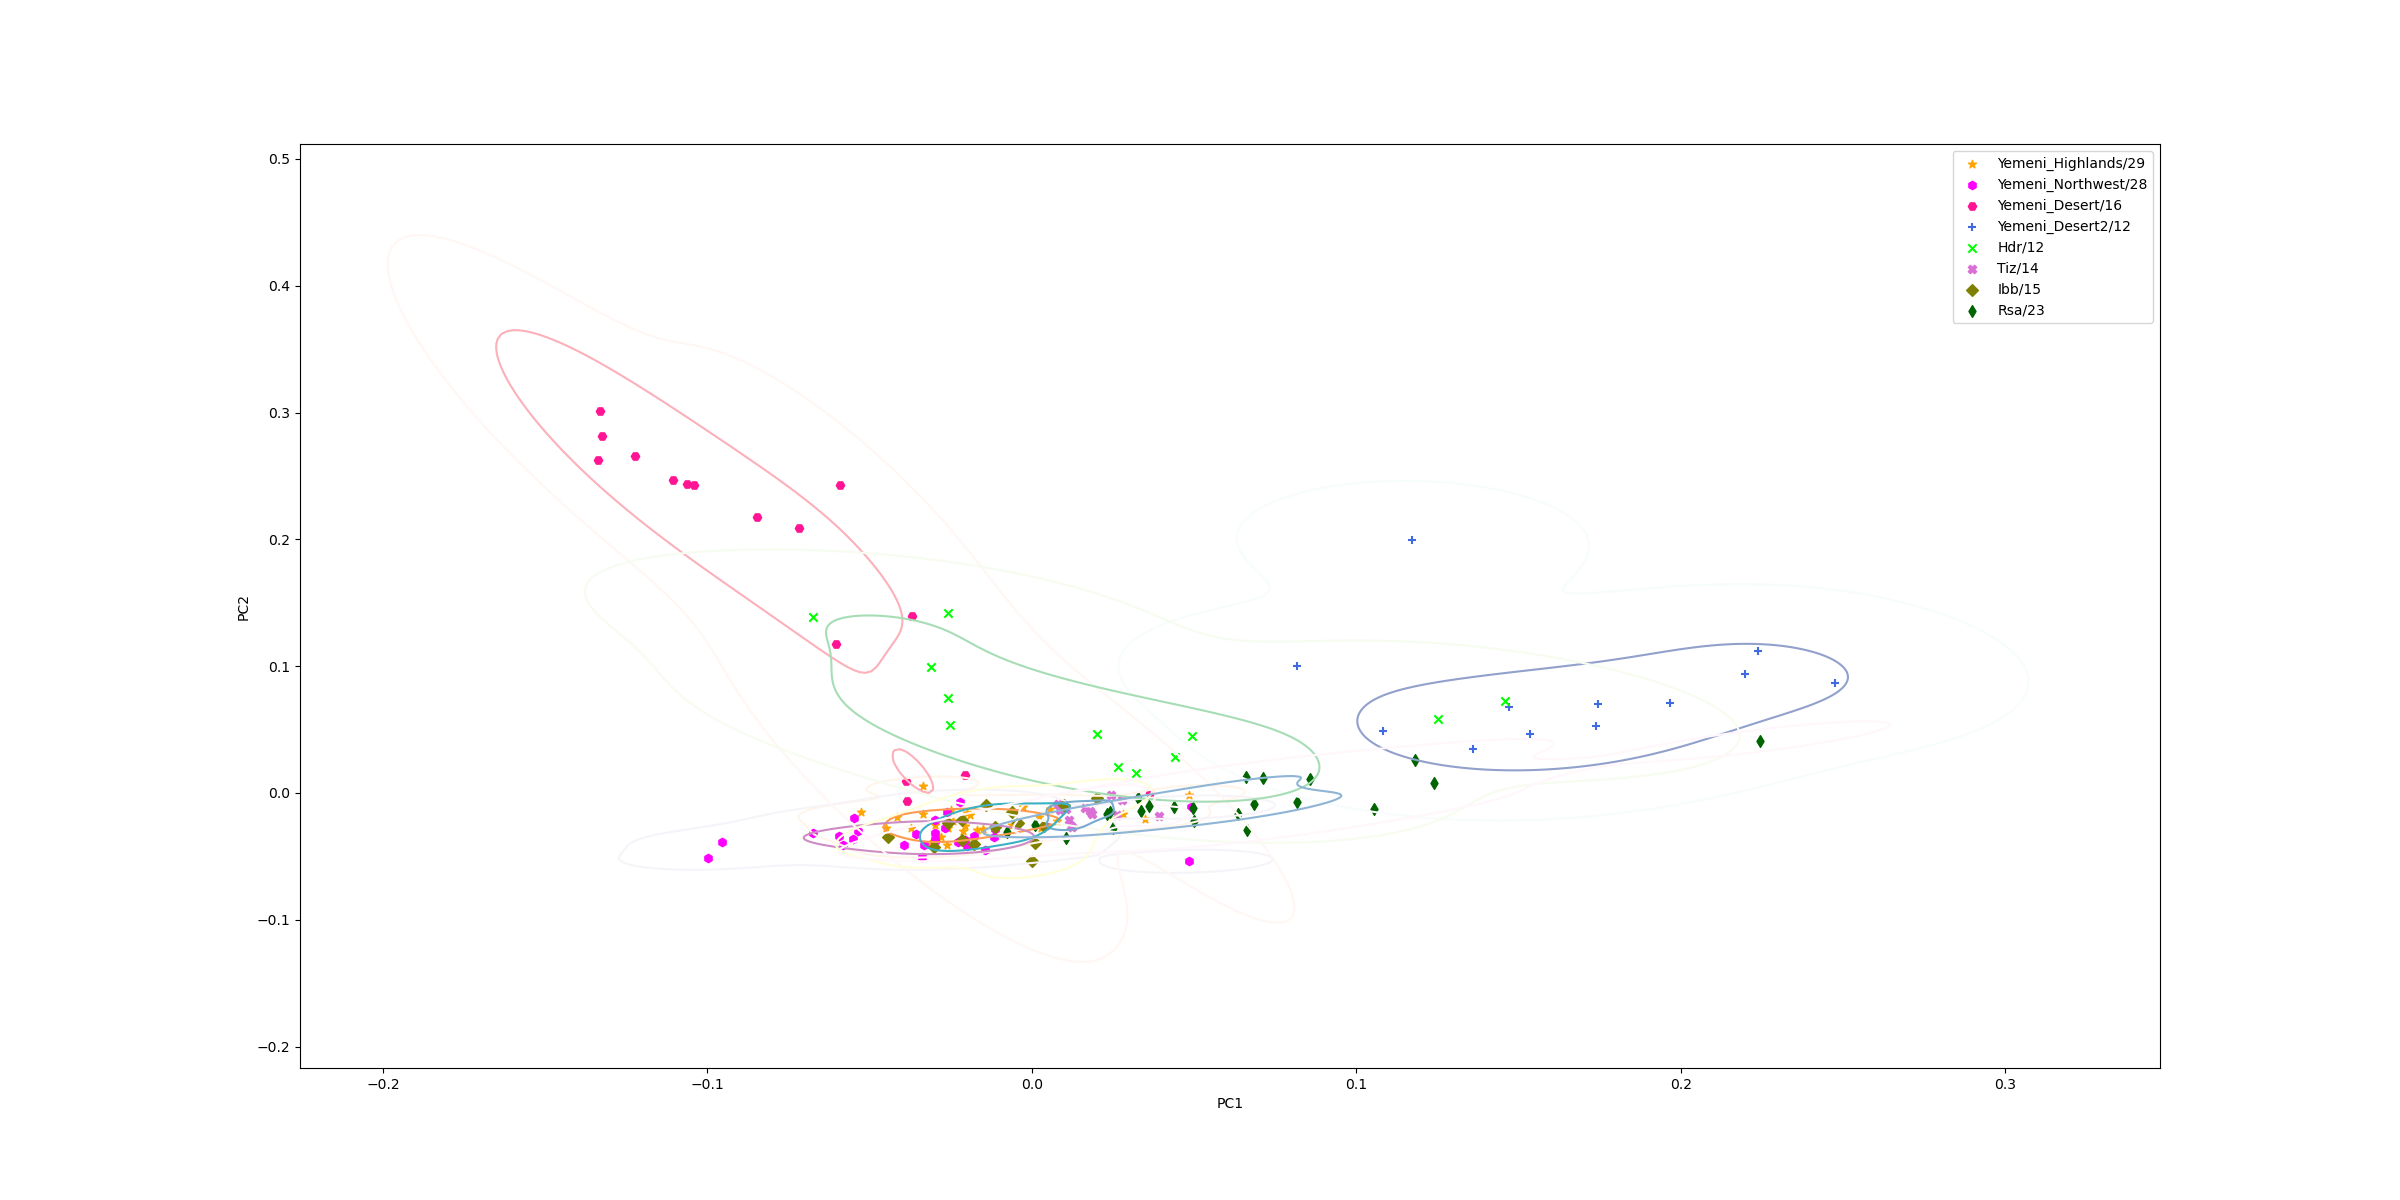

In [268]:
dataset='HO'
regions = [line.strip() for line in open(f"../Data/popfile_{dataset}_{1000}.txt")]
ddf = getPCAdata(dataset = "HO", geoPCA = 1000)

fig2, ax2 = plt.subplots(figsize=(24,12))

for pop in regions:
    #if pop=='Hdr':continue
    Y = ddf[ddf.Region==pop][['PC1', 'PC2']]
    if Y.shape[0] > 8:
        cmap = next(gradients)        
        sns.kdeplot(data=Y, x='PC1', y='PC2', cmap = cmap, ax=ax2, levels=3)
        color=next(gradcols)
        marker=next(markers)
        ax2.scatter(Y.PC1, Y.PC2, c=color, label=f'{pop}/{Y.shape[0]}', marker=marker)

ax2.legend()
plt.show()
plt.savefig("yemen4majorPops_Vyas1.svg")
plt.savefig("yemen4majorPops_Vyas1.png")

In [115]:
plt.savefig("yemen4majorPops.svg")

In [124]:
plt.savefig("yemen4majorPops_Vyas.svg")
plt.savefig("yemen4majorPops_Vyas.png")

## Increasing the context - Shaigi
PCA Plotting for regions within 2000km from Yemen. Remarkably Sudanese Shaigi appear close to Yemen Desert samples, much more so than more expected populaions like Somali.
Wikipedia: They trace their origin to a Hejazi Arab named Shaig who came from the Arabian Peninsula in the 7th century following the Arabian conquest of Egypt.[12] Shaig was a descendant of Abbas (an uncle of prophet Muhammad).

In [146]:
dataset='HO'
regions = [line.strip() for line in open(f"../Data/popfile_{dataset}_{2000}.txt")]
ddf = getPCAdata(dataset = dataset, geoPCA = 2000)
ddf

PC1     PC2     PC3     PC4     PC5     PC6     PC7  \
FID1                                                                      
MAL-005         -0.2702 -0.0386  0.0486  0.0009 -0.0511  0.0660 -0.0108   
MAL-009         -0.2666 -0.0332  0.0489  0.0085 -0.0573  0.0655 -0.0005   
MAL-011         -0.2723 -0.0331  0.0432  0.0109 -0.0580  0.0627 -0.0012   
MAL-012         -0.2698 -0.0340  0.0464  0.0109 -0.0482  0.0640 -0.0033   
MAL-014         -0.2684 -0.0314  0.0506  0.0134 -0.0559  0.0563  0.0022   
...                 ...     ...     ...     ...     ...     ...     ...   
3577STDY6068548  0.0085 -0.0258 -0.0258  0.0370 -0.0007  0.0180 -0.0226   
3577STDY6068568 -0.0353 -0.0000 -0.0096  0.0420 -0.0458  0.0712  0.0308   
3577STDY6068600 -0.0035  0.0057 -0.0318  0.0330 -0.0050  0.0522  0.0183   
3577STDY6068642  0.0081  0.0147 -0.0317 -0.0107  0.0422  0.0083  0.0016   
3577STDY6068643 -0.0009  0.0186 -0.0318  0.0460  0.0861  0.0268  0.0344   

                    PC8     PC9    PC10        Region  
FID1                                                   
MAL-005         -0.0361 -0.0060  0.0018    Malawi_Yao  
MAL-009         -0.0331 -0.0102  0.0013    Malawi_Yao  
MAL-011         -0.0352  0.0049 -0.0024  Malawi_Chewa  
MAL-012         -0.0349 -0.0007 -0.0039  Malawi_Chewa  
MAL-014         -0.0356  0.0033  0.0076  Malawi_Chewa  
...                 ...     ...     ...           ...  
3577STDY6068548 -0.0236 -0.0204 -0.0288           Amr  
3577STDY6068568 -0.0168  0.0100  0.0082           Rsa  
3577STDY6068600 -0.0269  0.0003  0.0190           Rsa  
3577STDY6068642 -0.0004 -0.0155 -0.0103           Tiz  
3577STDY6068643 -0.0603  0.0009  0.0262           Tiz  

[8845 rows x 11 columns]

In [142]:
Counter(ddf.Region)

Counter({'Spanish': 173, 'GWD.SG': 112, 'TSI.SG': 108, 'Han': 107, 'YRI.SG': 107, 'CHS.SG': 106, 'GIH.SG': 106, 'IBS.SG': 103, 'ITU.SG': 103, 'CHB.SG': 103, 'JPT.SG': 103, 'LWK.SG': 101, 'PUR.SG': 100, 'CDX.SG': 99, 'ESN.SG': 99, 'STU.SG': 99, 'CEU.SG': 99, 'Tibetan': 97, 'FIN.SG': 97, 'KHV.SG': 97, 'PJL.SG': 96, 'CLM.SG': 94, 'ACB.SG': 93, 'GBR.SG': 92, 'BEB.SG': 86, 'MSL.SG': 85, 'Russian': 71, 'Yoruba': 70, 'PEL.SG': 69, 'MXL.SG': 64, 'French': 61, 'ASW.SG': 60, 'Bashkir': 53, 'Turkish': 50, 'Han.SDG': 42, 'Sweden_Viking.SG': 41, 'Palestinian.SDG': 40, 'Druze': 39, 'Palestinian': 38, 'Iranian': 38, 'Buryat': 37, 'Druze.SDG': 37, 'Mongol': 34, 'Nganasan': 33, 'Mordovian': 32, 'Adygei': 31, 'Tajik': 31, 'Japanese': 29, 'Basque': 29, 'Yemeni_Highlands': 29, 'Yemeni_Northwest': 28, 'Tubalar': 27, 'Uzbek': 27, 'Sardinian': 27, 'Japanese.SDG': 27, 'Ulchi': 25, 'BedouinA': 25, 'BedouinB.SDG': 25, 'French.SDG': 25, 'Sardinian.SDG': 25, 'Altaian': 24, 'Selkup': 24, 'Russian.SDG': 24, 'Rsa': 

In [269]:
regions

['Afar.WGA', 'Saudi', 'Yemeni', 'Jew_Yemenite', 'Eritrea', 'Yemeni_Highlands', 'Yemeni_Highlands_Raymah', 'Yemeni_Northwest', 'Yemeni_Desert', 'Yemeni_Desert2', 'Jew_Yemenite.DG', 'Dal', 'Byd', 'Jwf', 'Abyn', 'Hdr', 'Amr', 'Tiz', 'Sad', 'San', 'Haj', 'Dhm', 'Mhw', 'Shb', 'Mrb', 'Lahj', 'Ibb', 'Rsa']

<IPython.core.display.Javascript object>


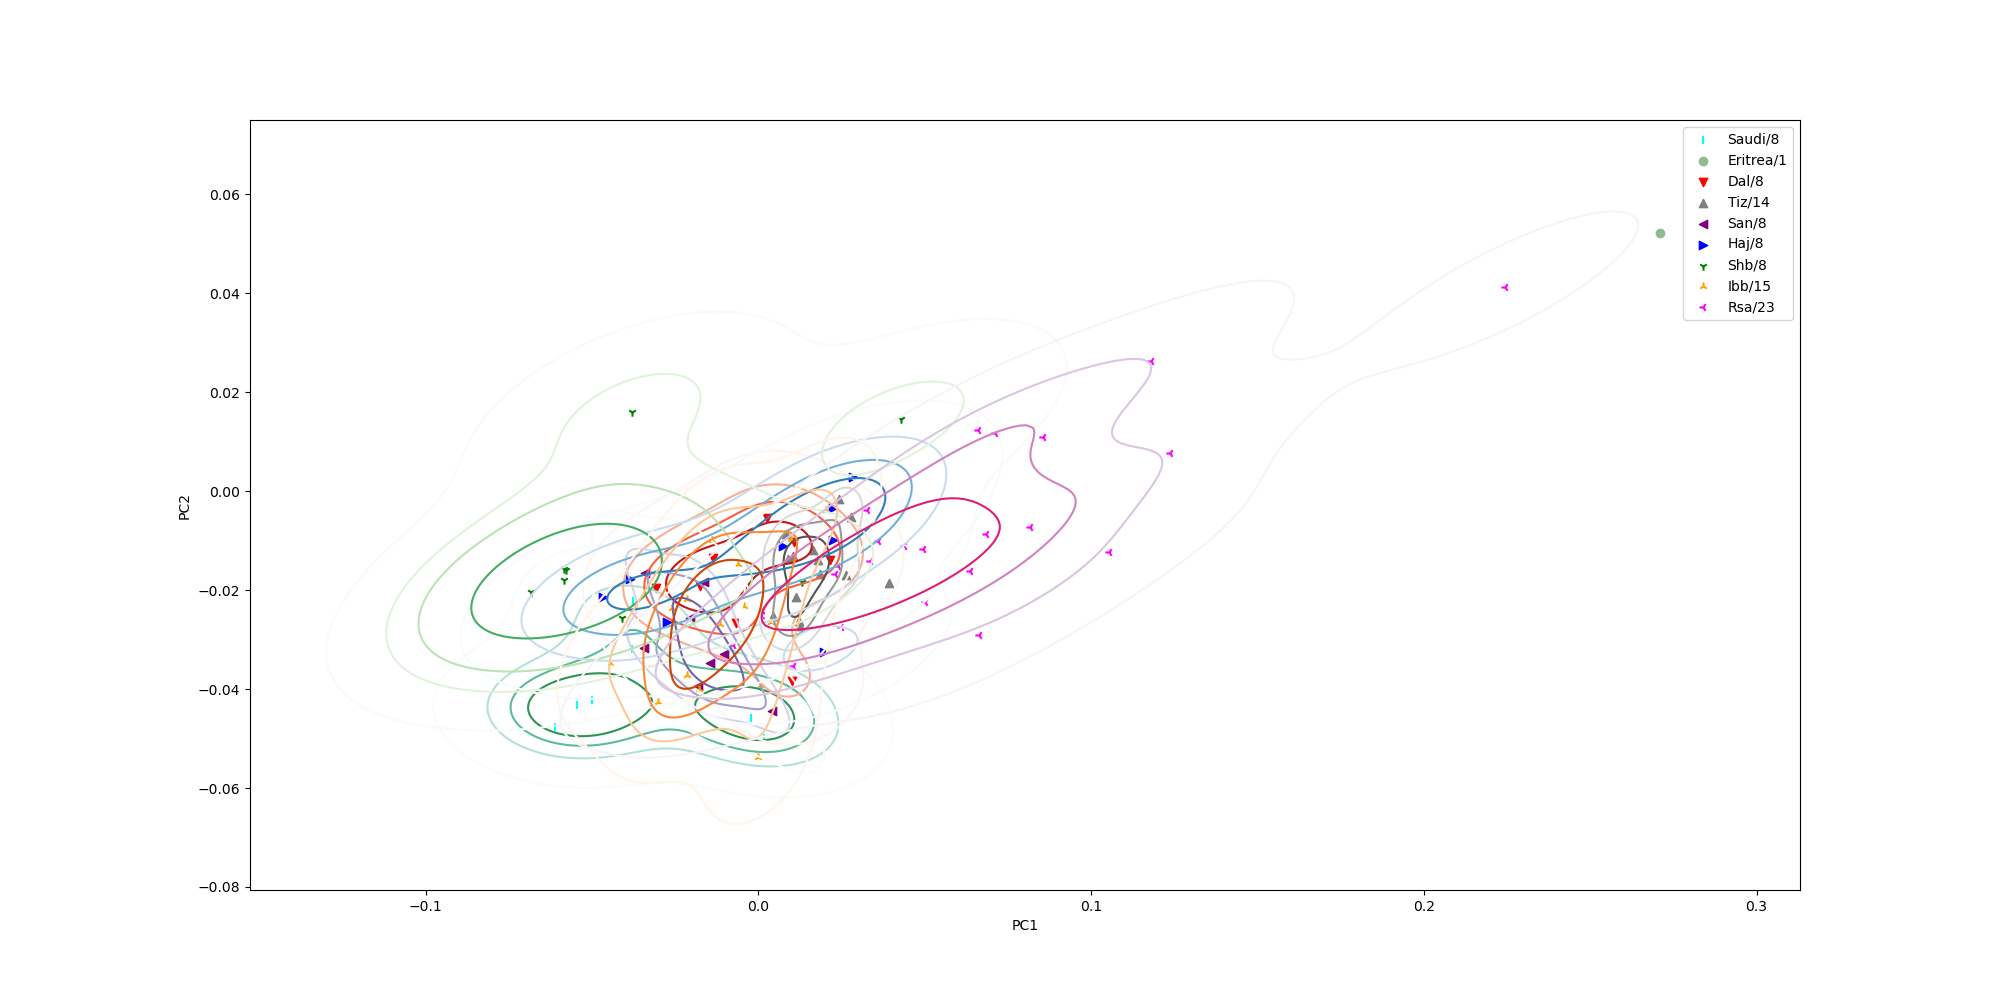

Afar.WGA 0
Saudi 8
Eritrea 1
Dal 8
Byd 3
Jwf 6
Abyn 6
Amr 6
Tiz 14
Sad 5
San 8
Haj 8
Dhm 6
Mhw 3
Shb 8
Mrb 4
Lahj 5
Ibb 15
Rsa 23


/home/ahenschel/miniconda3/envs/admix/lib/python3.9/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


In [270]:
fig2, ax3 = plt.subplots(figsize=(20,10))
             
for pop in regions:
    if 'Yemeni' in pop: continue
    if pop=='Hdr':continue ## makes it messy
    Y = ddf[ddf.Region==pop][['PC1', 'PC2']]
    print(pop, Y.shape[0])
    if Y.shape[0] >= 7 or pop in ['Shaigi.WGA', 'Eritrea', 'Dinka.DG']:

        cmap = next(gradients)        
        sns.kdeplot(data=Y, x='PC1', y='PC2', cmap = cmap, ax=ax3, levels=5)
        color=next(gradcols)
        marker=next(markers)
        ax3.scatter(Y.PC1, Y.PC2, c=color, label=f'{pop}/{Y.shape[0]}', marker=marker)

ax3.legend()
plt.show()

<IPython.core.display.Javascript object>


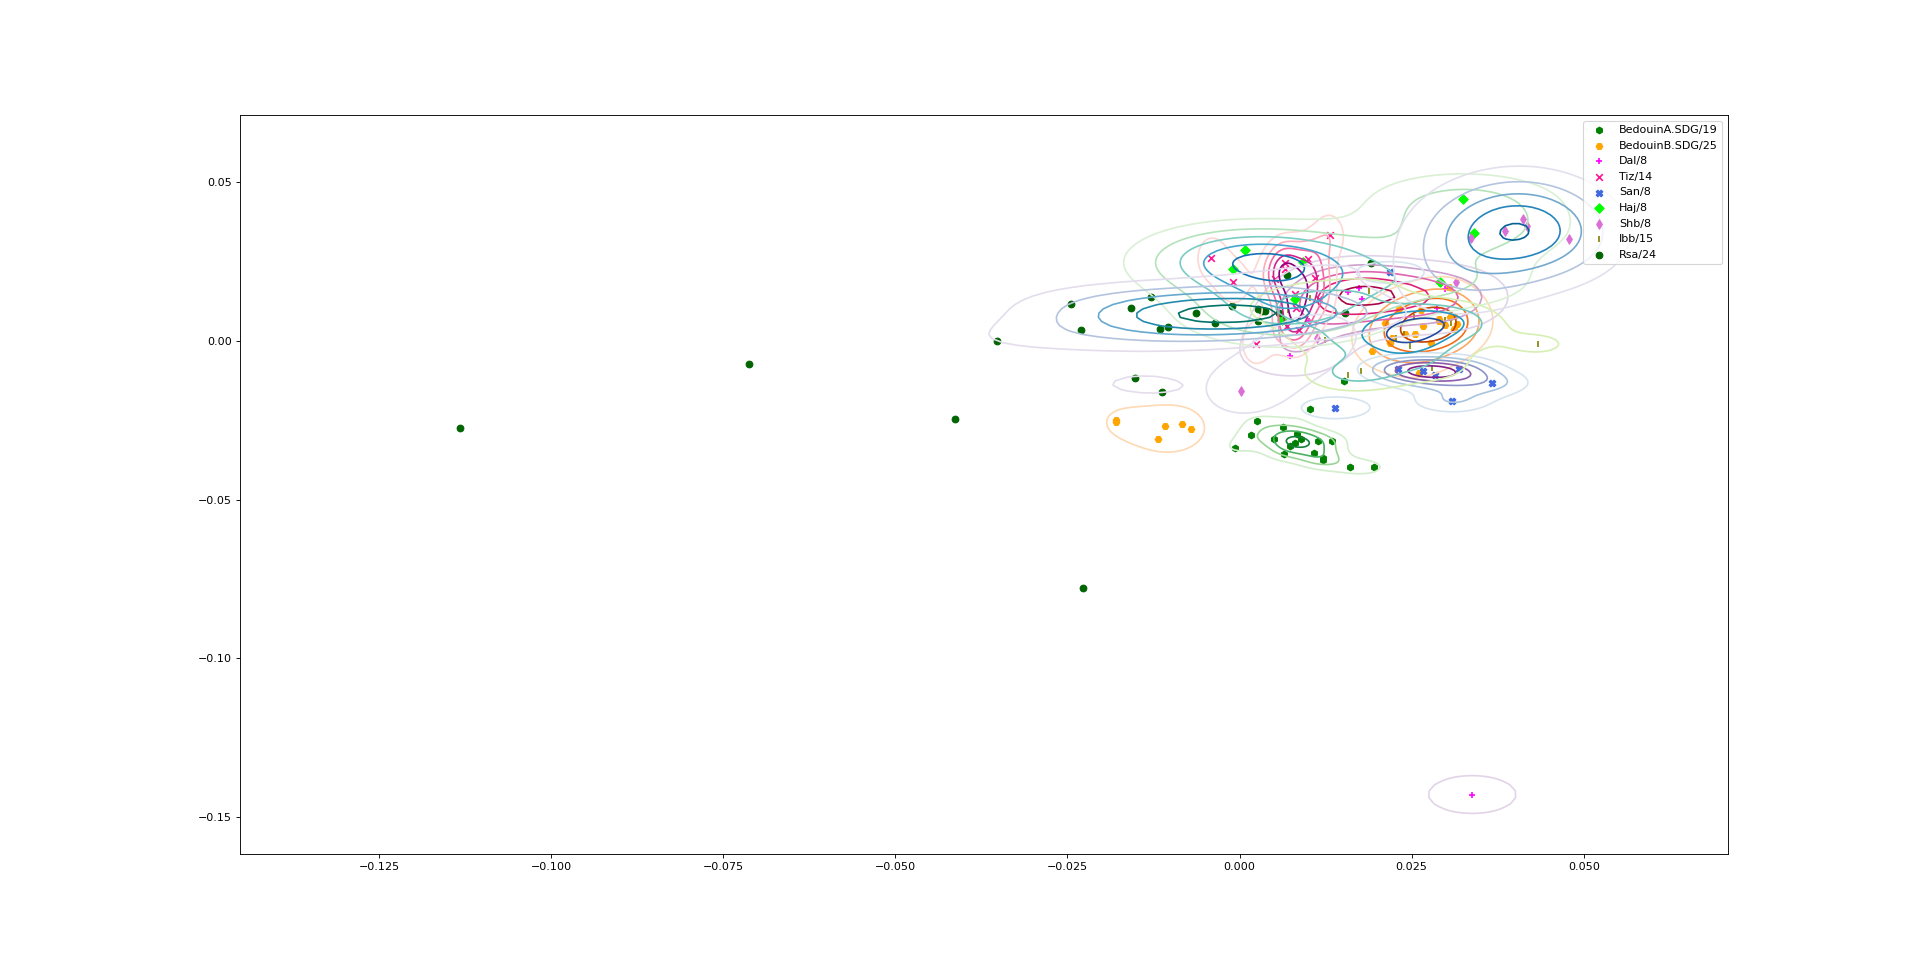

Dinka.DG 1
BedouinB.DG 2
Jew_Iraqi.DG 0
Luhya.DG 0
Jew_Yemenite.DG 0
Somali.DG 0
LWK.SG 101
BedouinA.SDG 19
BedouinB.SDG 25
Dal 8
Byd 3
Jwf 6
Abyn 6
Amr 6
Tiz 14
Sad 5
San 8
Haj 8
Dhm 6
Mhw 3
Shb 8
Mrb 4
Lahj 5
Ibb 15
Rsa 24


In [163]:
dataset='1240K'
regions = [line.strip() for line in open(f"../Data/popfile_{dataset}_{2000}.txt")]
ddf = getPCAdata(dataset = "HO", geoPCA = 2000)

fig2, ax3 = plt.subplots(figsize=(24,12))
             
for pop in regions:
    if pop=='Hdr':continue ## makes it messy
    Y = ddf[ddf.Region==pop][['PC1', 'PC2']]
    print(pop, Y.shape[0])
    if Y.shape[0] >= 7 and pop!="LWK.SG":

        cmap = next(gradients)        
        sns.kdeplot(Y, cmap = cmap, ax=ax3, levels=5)
        color=next(gradcols)
        marker=next(markers)
        ax3.scatter(Y.PC1, Y.PC2, c=color, label=f'{pop}/{Y.shape[0]}', marker=marker)

ax3.legend()
plt.show()

## Extended Population definitions
Defining populations into larger groups.


In [19]:
## outliers as identified by smartPCA (for yemen only!)
outliers = ['3577STDY6068395', '3577STDY6068419', '3577STDY6068451', '3577STDY6068377', '3577STDY6068387', '3577STDY6068378', '3577STDY6068410', '3577STDY6068418', '3577STDY6068440', '3577STDY6068483', '3577STDY6068505', '3577STDY6068520', '3577STDY6068475', '3577STDY6068490', '3577STDY6068617', '3577STDY6068528', '3577STDY6068625', '3577STDY6068386', '3577STDY6068426', '3577STDY6068458', '3577STDY6068449', '3577STDY6068529', '3577STDY6068506', '3577STDY6068522', '3577STDY6068466', '3577STDY6068526', '3577STDY6068481', '3577STDY6068411', '3577STDY6068456', '3577STDY6068495', '3577STDY6068497', '3577STDY6068364', '3577STDY6068491']


Reading from PCA file ../AdmixTools_HO_mind0.3_geno_0.2/yemen_reichHO_mind0.3_geno_0.2.LD.QC3.pcs.txt


<IPython.core.display.Javascript object>


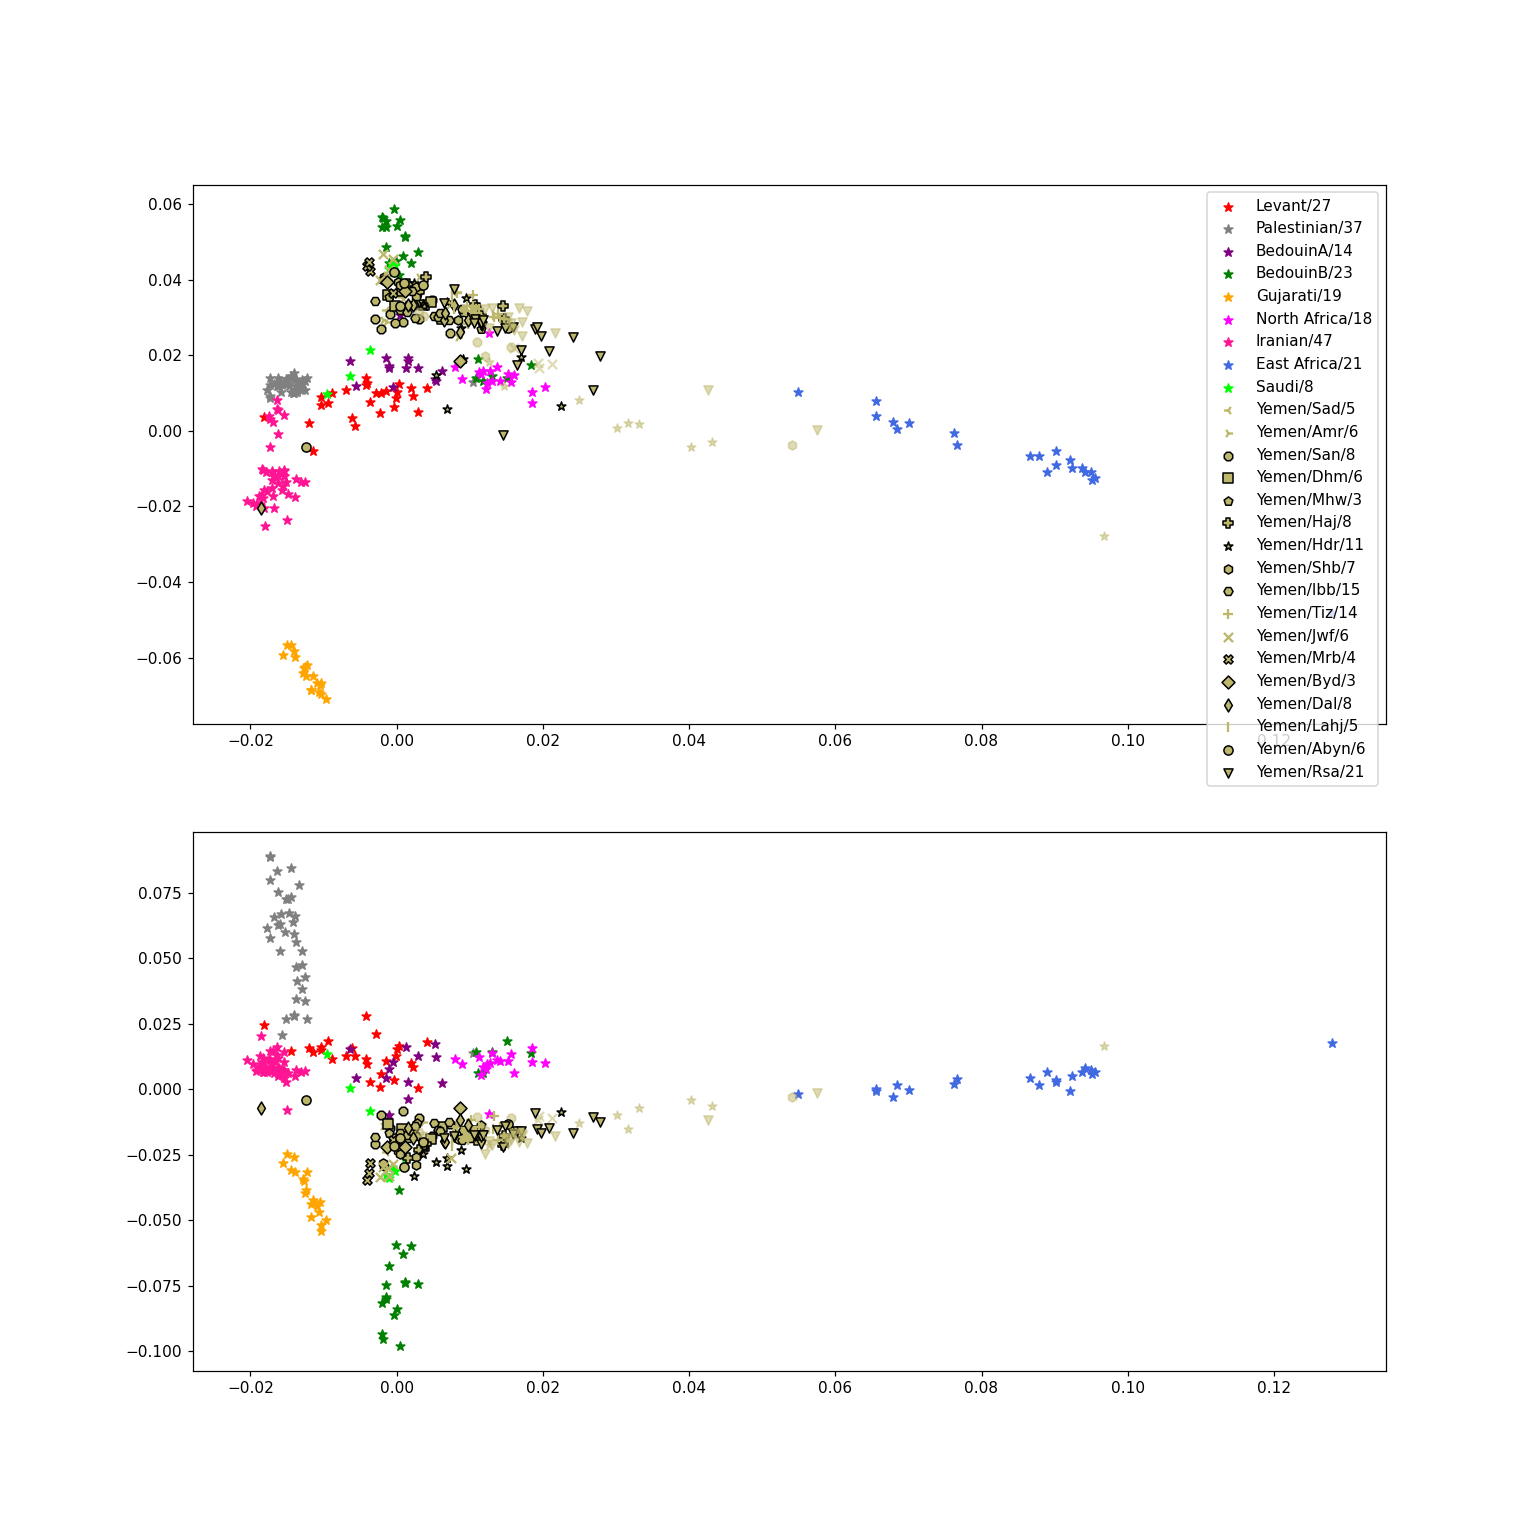

/tmp/ipykernel_96642/2130201112.py:38: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('3').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax3.scatter(Y.PC1, Y.PC2, c=color, label=f'Yemen/{pop}/{Y.shape[0]}', marker=marker, edgecolors='k')
/tmp/ipykernel_96642/2130201112.py:39: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('3').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax4.scatter(Y.PC1, Y.PC3, c=color, marker=marker, edgecolors='k')
/tmp/ipykernel_96642/2130201112.py:38: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('4').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax3.scatter(Y.PC1, Y.PC2, c=color, label=f'Yemen/{pop}/{Y.shape[0]}', marker=marker, edgecolors='k')
/tmp/ipykernel_96642/2130201112.py:39: Use

In [20]:
#gradients = itertools.cycle([ 'Reds', 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'PuRd',    'RdPu',     'BuPu',       'GnBu', 'PuBu',    'YlGnBu', 'PuBuGn',  'BuGn', 'YlGn'])
gradcols  = itertools.cycle([ 'Red', 'Grey',   'Purple',  'Green',  'Orange',  'fuchsia', 'deeppink', 'royalblue',  'lime', 'orchid',  'olive',  'darkgreen','cyan', 'darkseagreen'])
regions = [line.strip() for line in open(f"../Data/popfile_{dataset}_{3000}.txt")]
regionDict = {'Levant': ['Syrian', 'Jordanian', 'Lebanese', 'Druze_oAfrican.SDG'],
              'Palestinian': ['Palestinian_o2.SDG', 'Druze.SDG', 'Palestinian_o1.SDG'], 
              
           'BedouinA': ['BedouinA.SDG'], 
           'BedouinB': ['BedouinB.SDG'],
           #'Yemen_Vyas': ['Yemeni_Highlands', 'Yemeni_Highlands_Raymah', 'Yemeni_Northwest', 'Yemeni_Desert', 'Yemeni_Desert2'],
           'Gujarati': ['GujaratiD', 'GujaratiB', 'GujaratiA', 'GujaratiC'],
           'North Africa': ["Egyptian"],
           'Iranian': ['Iranian', 'Jew_Iranian'], 
              
              #'Iranian2': ['Iranian_Bandari', 'Iranian.DG'],
           'East Africa': ['Somali', 'Eritrea', 'Afar.WGA', 'Ethiopia' 'Jew_Ethiopian', 'Ethiopia_4500BP_published.SG'], 
              'Saudi': ['Saudi']}
#           'Shaigi': ['Shaigi.WGA', 'Dinka.DG'][:1]}
#regionDictY = {'Yemen_Zalloua_NoHdr': ['Dal', 'Byd', 'Jwf', 'Abyn', 'Amr', 'Tiz', 'Sad', 'San', 'Haj', 'Dhm', 'Mhw', 'Shb', 'Mrb', 'Lahj', 'Ibb', 'Rsa']}

ddf = getPCAdata(dataset = "HO", geoPCA = 3000)
#ddf = ddf[~ddf.index.isin(outliers)]

fig2, ax = plt.subplots(nrows=2, figsize=(14,14))
ax3, ax4 = ax      
## Non-Yemen
for pop, poplist in regionDict.items():
    Y = ddf[ddf.Region.isin(poplist)] 
    #sns.kdeplot(data=Y,x='PC1',y='PC2', cmap = cmap, ax=ax3, levels=5)    
    color=next(gradcols)
    marker='*' #next(markers)
    ax3.scatter(Y.PC1, Y.PC2, c=color, label=f'{pop}/{Y.shape[0]}', marker=marker)
    ax4.scatter(Y.PC1, Y.PC3, c=color, marker=marker)
## Yemen, differentiate by marker
for pop in yregions:
    color = 'darkkhaki'
    marker = next(markers)
    Y = ddf[(ddf.Region==pop) & (~ddf.index.isin(outliers))]
    ax3.scatter(Y.PC1, Y.PC2, c=color, label=f'Yemen/{pop}/{Y.shape[0]}', marker=marker, edgecolors='k')
    ax4.scatter(Y.PC1, Y.PC3, c=color, marker=marker, edgecolors='k')
    Y = ddf[(ddf.Region==pop) & (ddf.index.isin(outliers))]
    if len(Y)>0:
        ax3.scatter(Y.PC1, Y.PC2, c=color, alpha=0.5, marker=marker)
        ax4.scatter(Y.PC1, Y.PC3, c=color, alpha=0.5, marker=marker)


    
# Yemen outliers
        
ax3.legend(loc = 'upper right' ) #, bbox_to_anchor=(1.1, 1.0))                      
           


In [22]:
fig2.savefig('extendedPops.svg')

In [38]:
ddf[ddf.Region.str.contains('thiop')]

PC1     PC2     PC3     PC4     PC5     PC6     PC7  \
FID1                                                                      
thiopianJew1818  0.0708  0.0026  0.0029 -0.0105  0.0163 -0.0112 -0.0128   
thiopianJew4690  0.0705  0.0001  0.0021 -0.0049  0.0102 -0.0101  0.0026   
thiopianJew1574  0.0704  0.0024  0.0027 -0.0137  0.0108 -0.0179 -0.0121   
thiopianJew1804  0.0708 -0.0001  0.0000 -0.0074  0.0181 -0.0122 -0.0089   
thiopianJew1822  0.0688  0.0008 -0.0028 -0.0078  0.0128 -0.0105 -0.0088   
thiopianJew1570  0.0725  0.0011 -0.0004 -0.0025  0.0197 -0.0046  0.0029   
thiopianJew1831  0.0696  0.0033  0.0036 -0.0082  0.0087 -0.0020 -0.0025   
mota.SG          0.1279 -0.0482  0.0178  0.0092 -0.0096  0.0007 -0.0066   

                    PC8     PC9    PC10                        Region  
FID1                                                                   
thiopianJew1818 -0.0030  0.0216  0.0015                 Jew_Ethiopian  
thiopianJew4690  0.0073  0.0123  0.0068                 Jew_Ethiopian  
thiopianJew1574 -0.0000  0.0137 -0.0021                 Jew_Ethiopian  
thiopianJew1804 -0.0034  0.0197  0.0060                 Jew_Ethiopian  
thiopianJew1822 -0.0005  0.0245 -0.0022                 Jew_Ethiopian  
thiopianJew1570  0.0041  0.0202  0.0175                 Jew_Ethiopian  
thiopianJew1831 -0.0003  0.0238 -0.0072                 Jew_Ethiopian  
mota.SG         -0.0025  0.0115  0.0026  Ethiopia_4500BP_published.SG

In [315]:
fig2.savefig('pca_extendedPops_3000_pc123.svg')

In [302]:
regions

['Armenian_Hemsheni', 'Azeri', 'Tabasaran', 'Darginian', 'Kubachinian', 'Lak', 'Avar_outlier1', 'Avar', 'Avar_outlier2', 'Kaitag', 'Ezid', 'Georgian', 'Brahui', 'Balochi', 'Makrani', 'Sindhi_Pakistan', 'Mbuti', 'Druze', 'BedouinB', 'BedouinA', 'Palestinian', 'BantuKenya', 'Somali', 'Kikuyu', 'Masai', 'Hadza1', 'Afar.WGA', 'Armenian.WGA', 'Azeri.WGA', 'Shaigi.WGA', 'Kurd.WGA', 'Georgian.WGA', 'Assyrian.WGA', 'Iranian', 'Syrian', 'Lebanese', 'Jordanian', 'Saudi', 'Yemeni', 'Egyptian', 'Armenian', 'Lezgin', 'Luhya', 'GujaratiD', 'GujaratiB', 'GujaratiA', 'GujaratiC', 'Luo', 'Datog', 'Jew_Ethiopian', 'Jew_Yemenite', 'Turkish', 'Jew_Iranian', 'Jew_Iraqi', 'Cypriot', 'Jew_Georgian', 'Lebanese_Christian', 'Lebanese_Muslim', 'Iranian_Bandari', 'Assyrian', 'Eritrea', 'Yemeni_Highlands', 'Yemeni_Highlands_Raymah', 'Yemeni_Northwest', 'Yemeni_Desert', 'Yemeni_Desert2', 'Dinka.DG', 'Jordanian.DG', 'Luo.DG', 'Mbuti.DG', 'BedouinB.DG', 'Jew_Iraqi.DG', 'Druze.DG', 'Sindhi_Pakistan.DG', 'Iranian.DG', 

<IPython.core.display.Javascript object>


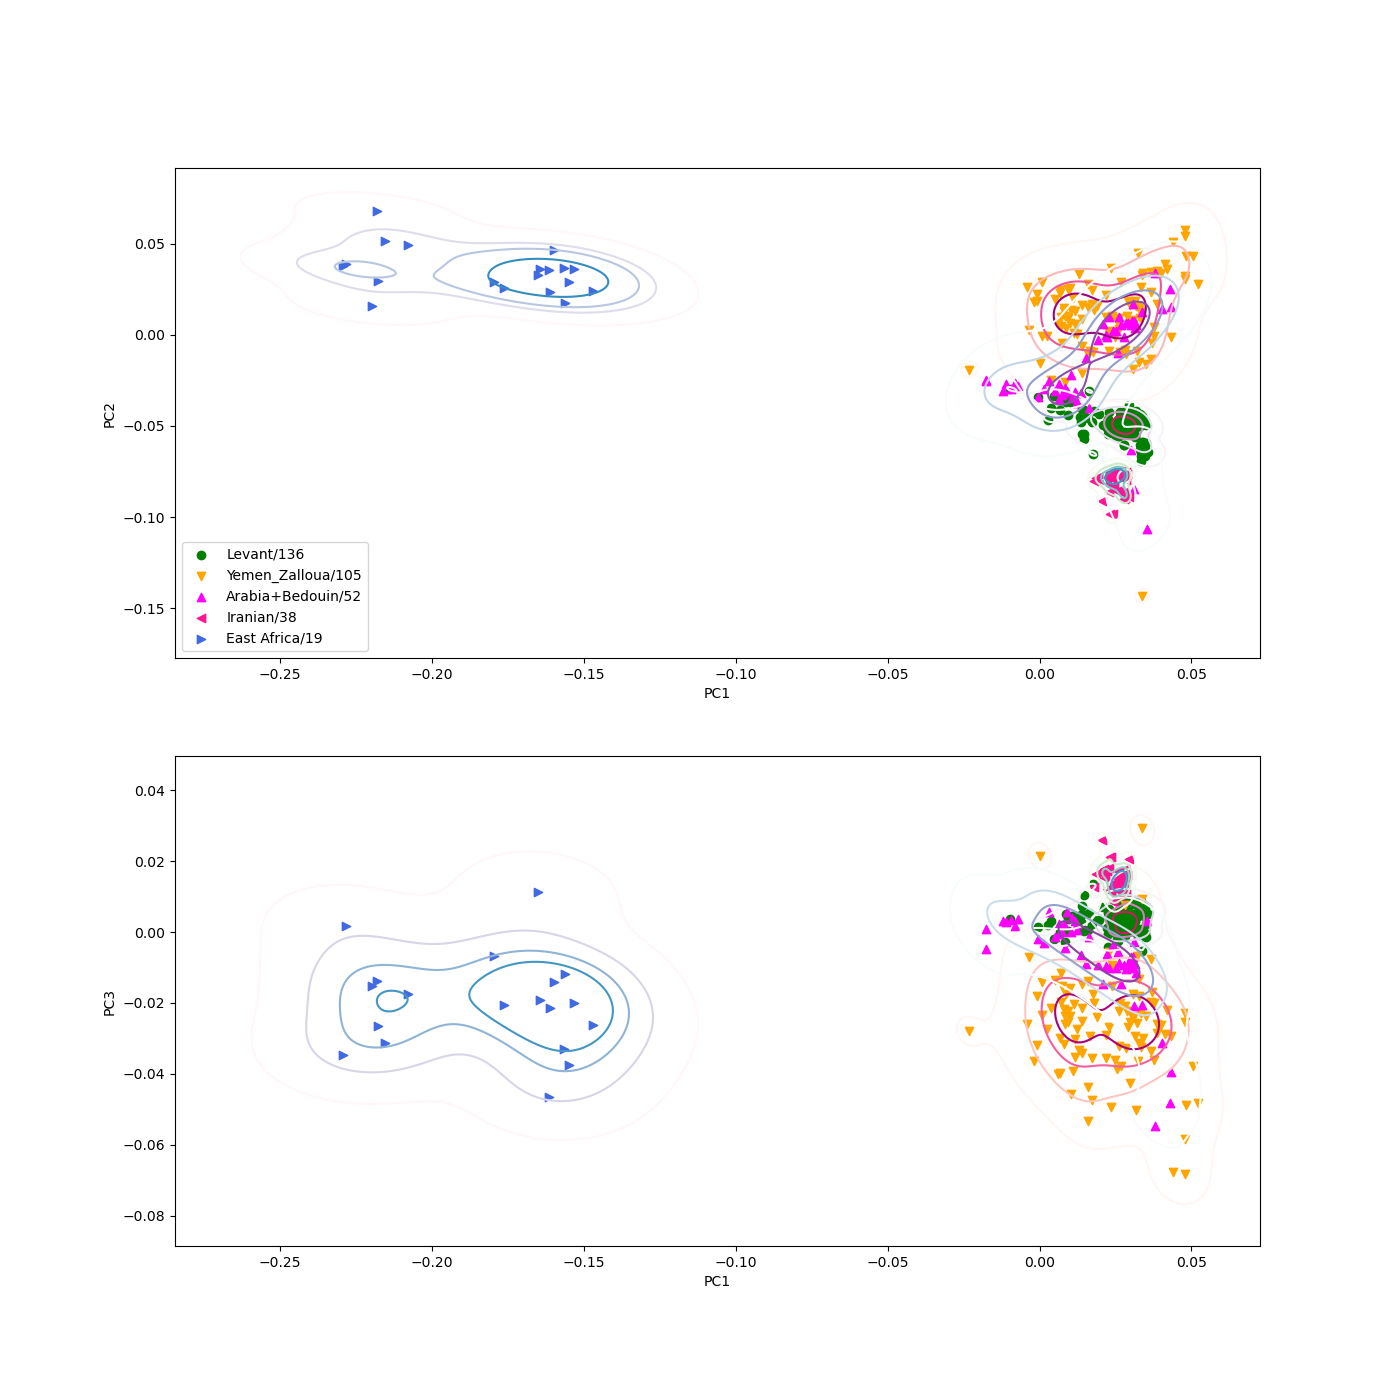

Levant 136
Yemen_Zalloua 105
Arabia+Bedouin 52
Iranian 38
East Africa 19


In [295]:
ddf = getPCAdata(dataset = "HO", geoPCA = 2000)
regionDict = {'Levant': ['Syrian', 'Jordanian', 'Lebanese', 'Druze_oAfrican.SDG', 'Druze', 'Palestinian_o2.SDG', 'Druze.SDG', 'Palestinian_o1.SDG', 'Lebanese_Christian', 'Lebanese_Muslim', 'Assyrian'], 
              'Yemen_Zalloua': ['Dal', 'Byd', 'Jwf', 'Abyn', 'Amr', 'Tiz', 'Sad', 'San', 'Haj', 'Dhm', 'Mhw', 'Shb', 'Mrb', 'Lahj', 'Ibb'],
               #'Bedouin': ['BedouinA.SDG', 'BedouinB.SDG'],
              'Arabia+Bedouin': ['Saudi','BedouinB', 'BedouinA'],
               #'Yemen_Vyas': ['Yemeni_Highlands', 'Yemeni_Highlands_Raymah', 'Yemeni_Northwest', 'Yemeni_Desert', 'Yemeni_Desert2'],
               'Iranian': ['Iranian'], #, 'Jew_Iranian', 'Iranian_Bandari', 'Iranian.DG'],
               'East Africa': ['Afar.WGA', 'Somali', 'Jew_Ethiopian']
             }
fig2, ax = plt.subplots(nrows=2, figsize=(14,14))
        
ax3, ax4 = ax
for pop in regionDict: #'Arabia Levant Yemen_Zalloua Levant Sudan Saudi'.split():
    poplist = regionDict[pop]
    Y = ddf[ddf.Region.isin(poplist)]
    print(pop, Y.shape[0])

    cmap = next(gradients)        
    sns.kdeplot(data=Y, x='PC1',y='PC2', cmap = cmap, ax=ax3, levels=5)
    sns.kdeplot(data=Y, x='PC1',y='PC3', cmap = cmap, ax=ax4, levels=5)
    color=next(gradcols)
    marker=next(markers)

    ax3.scatter(Y.PC1, Y.PC2, c=color, label=f'{pop}/{Y.shape[0]}', marker=marker)
    ax4.scatter(Y.PC1, Y.PC3, c=color, marker=marker)

ax3.legend()


In [300]:
fig2.savefig('../Results/pcaKDE_2000_noHdrRsa2.svg')
#!pwd

In [180]:
dataset='HO'
regions = [line.strip() for line in open(f"../Data/popfile_{dataset}_{3000}.txt")]
ddf = getPCAdata(dataset = "HO", geoPCA = 2000)
cs = [(region, Counter(ddf.Region)[region])for region in regions]

    

## PC1 vs PC3
Shaigi still very close to Yemeni Desert2 and Rsa!

<IPython.core.display.Javascript object>


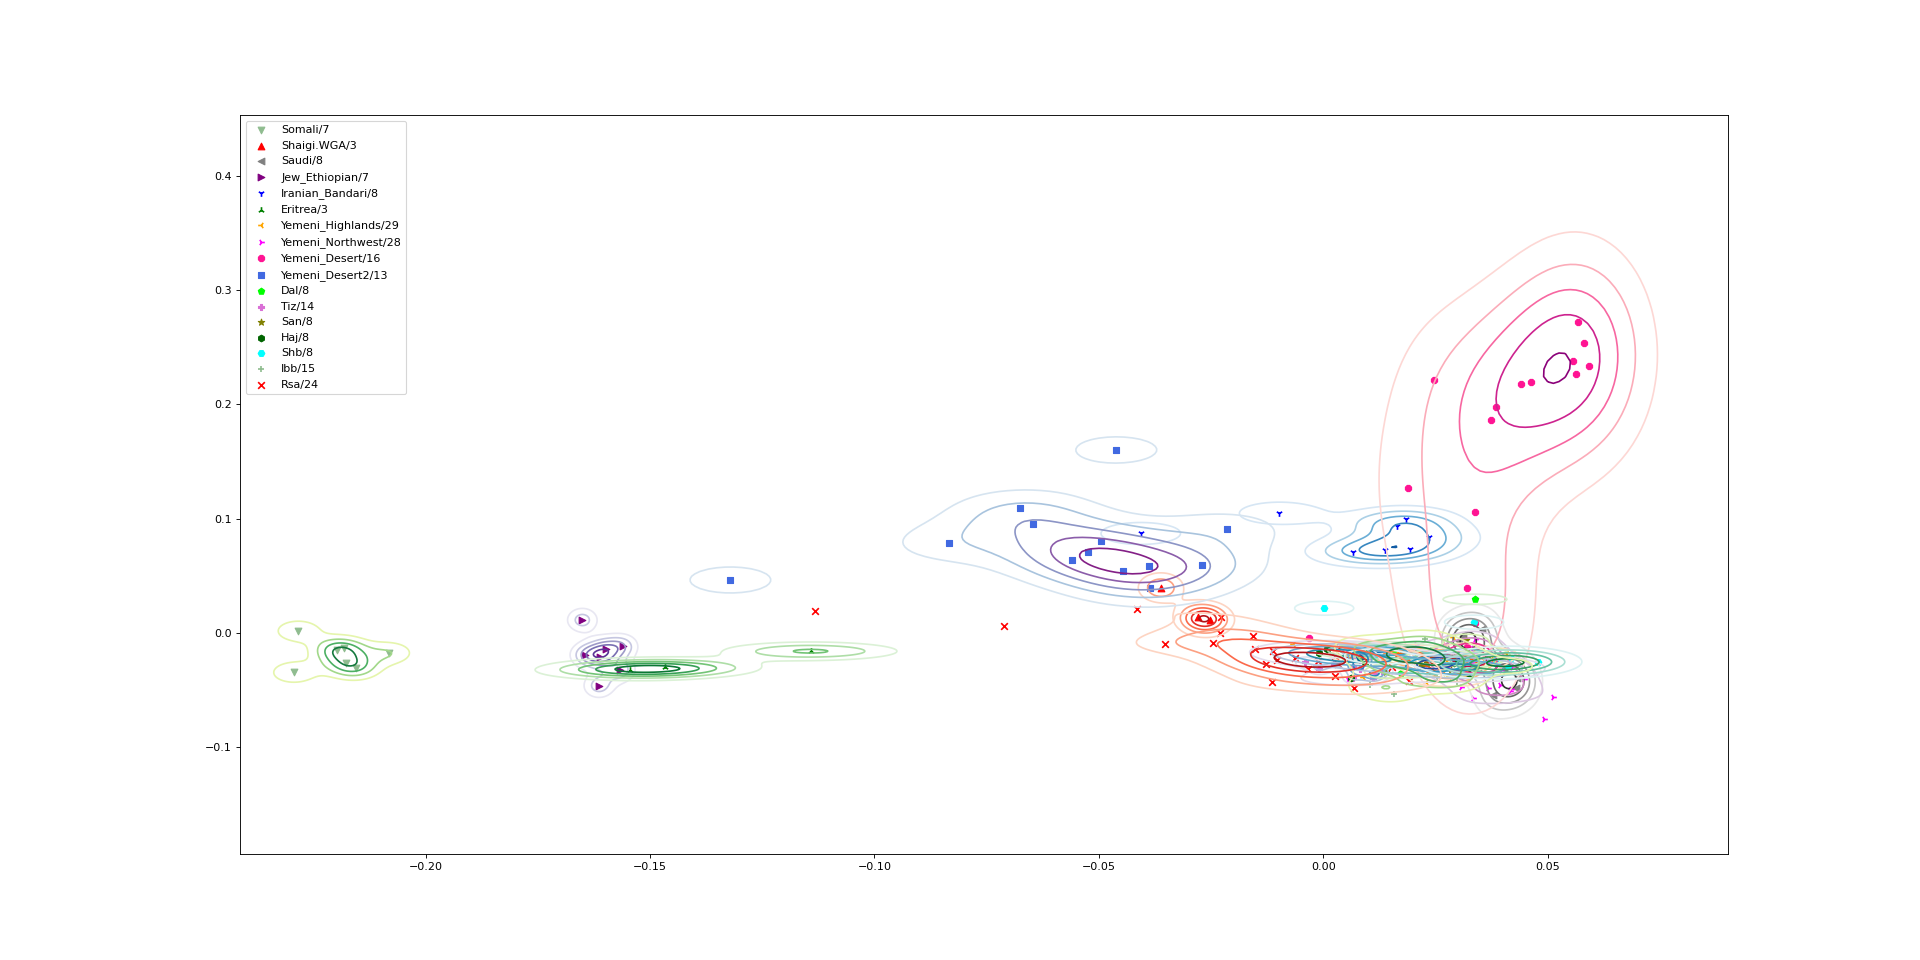

Somali 7
Afar.WGA 5
Shaigi.WGA 3
Saudi 8
Yemeni 6
Luhya 0
Jew_Ethiopian 7
Jew_Yemenite 6
Jew_Iraqi 4
Iranian_Bandari 8
Eritrea 3
Yemeni_Highlands 29
Yemeni_Highlands_Raymah 1
Yemeni_Northwest 28
Yemeni_Desert 16
Yemeni_Desert2 13
Jew_Iraqi.DG 0
Luhya.DG 0
Jew_Yemenite.DG 0
Somali.DG 0
Dal 8
Byd 3
Jwf 6
Abyn 6
Amr 6
Tiz 14
Sad 5
San 8
Haj 8
Dhm 6
Mhw 3
Shb 8
Mrb 4
Lahj 5
Ibb 15
Rsa 24


In [134]:
dataset='HO'
regions = [line.strip() for line in open(f"../Data/popfile_{dataset}_{2000}.txt")]
ddf = getPCAdata(dataset = "HO", geoPCA = 2000)

fig2, ax3 = plt.subplots(figsize=(24,12))
             
for pop in regions:
    if pop=='Hdr':continue ## makes it messy
    Y = ddf[ddf.Region==pop][['PC1', 'PC3']]
    print(pop, Y.shape[0])
    if Y.shape[0] >= 7 or pop in ['Shaigi.WGA', 'Eritrea']:

        cmap = next(gradients)        
        sns.kdeplot(Y, cmap = cmap, ax=ax3, levels=5)
        color=next(gradcols)
        marker=next(markers)
        ax3.scatter(Y.PC1, Y.PC3, c=color, label=f'{pop}/{Y.shape[0]}', marker=marker)

ax3.legend()
plt.show()

<IPython.core.display.Javascript object>


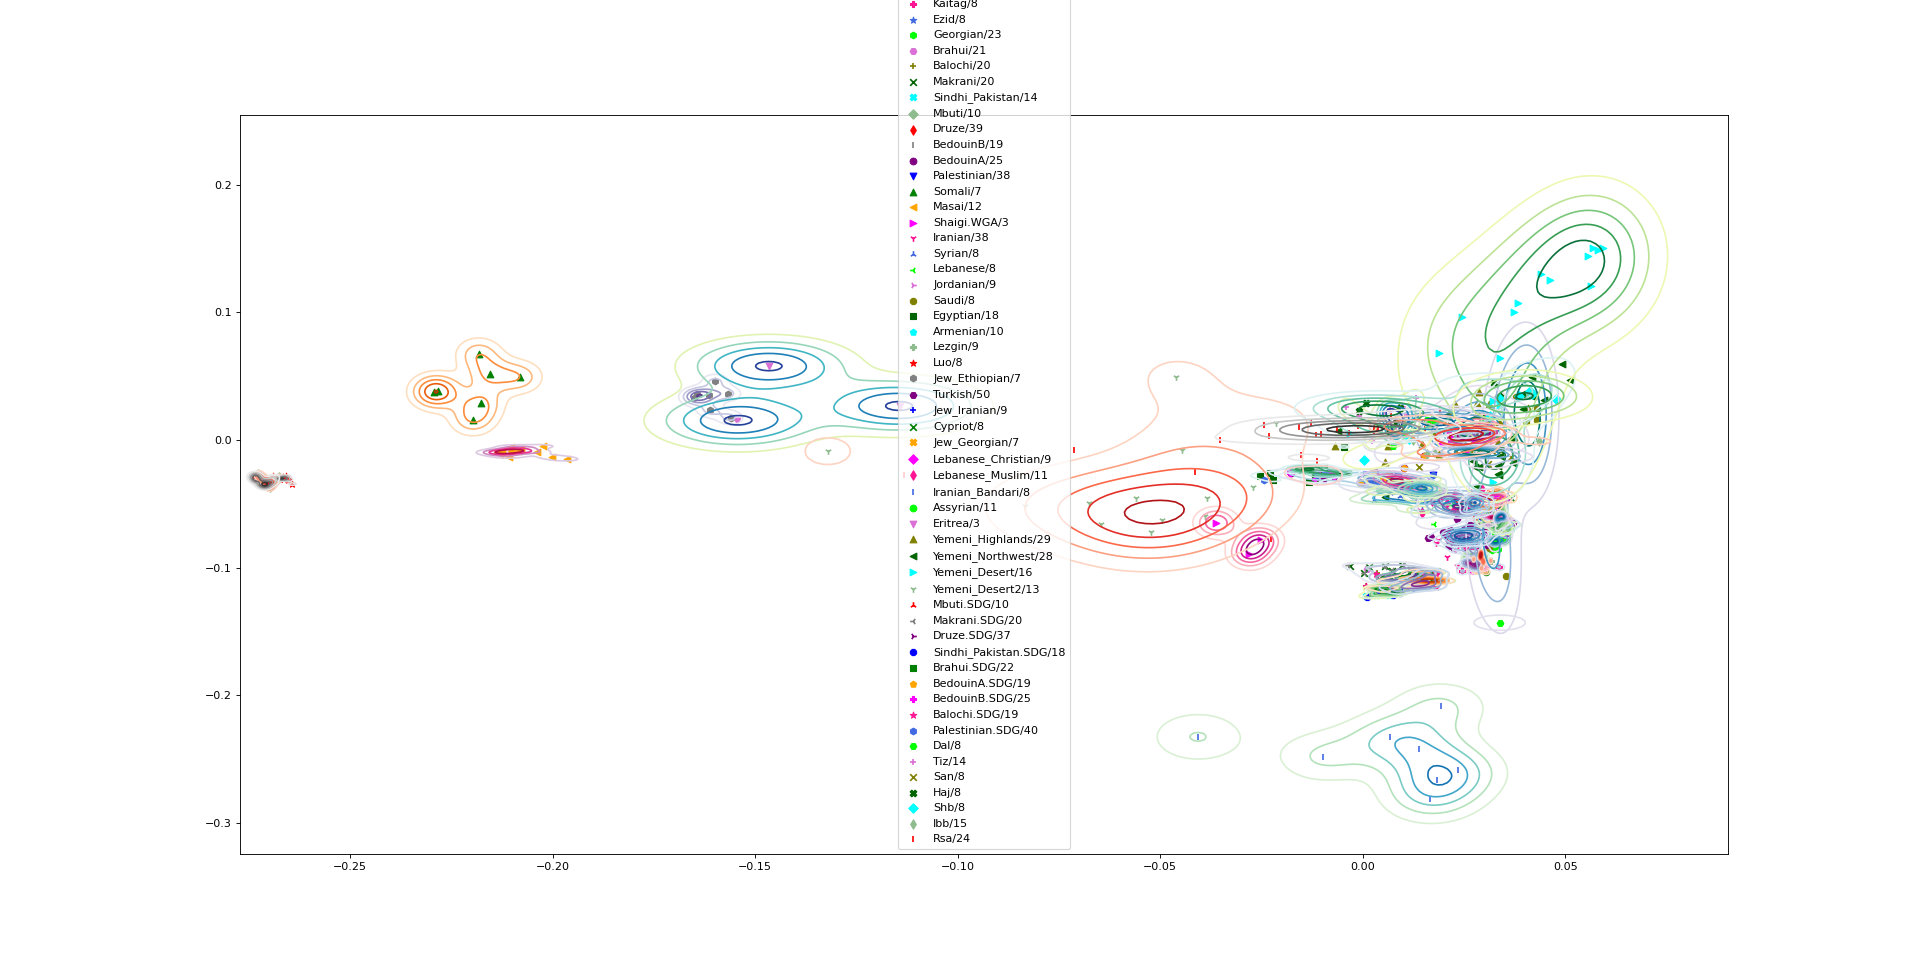

Armenian_Hemsheni 8
Azeri 17
Tabasaran 10
Darginian 8
Kubachinian 6
Lak 10
Avar_outlier1 0
Avar 8
Avar_outlier2 0
Kaitag 8
Ezid 8
Georgian 23
Brahui 21
Balochi 20
Makrani 20
Sindhi_Pakistan 14
Mbuti 10
Druze 39
BedouinB 19
BedouinA 25
Palestinian 38
BantuKenya 6
Somali 7
Kikuyu 4
Masai 12
Hadza1 4
Afar.WGA 5
Armenian.WGA 3
Azeri.WGA 3
Shaigi.WGA 3
Kurd.WGA 2
Georgian.WGA 2
Assyrian.WGA 4
Iranian 38
Syrian 8
Lebanese 8
Jordanian 9
Saudi 8
Yemeni 6
Egyptian 18
Armenian 10
Lezgin 9
Luhya 0
GujaratiD 5
GujaratiB 5
GujaratiA 4
GujaratiC 5
Luo 8
Datog 3
Jew_Ethiopian 7
Jew_Yemenite 6
Turkish 50
Jew_Iranian 9
Jew_Iraqi 4
Cypriot 8
Jew_Georgian 7
Lebanese_Christian 9
Lebanese_Muslim 11
Iranian_Bandari 8
Assyrian 11
Eritrea 3
Yemeni_Highlands 29
Yemeni_Highlands_Raymah 1
Yemeni_Northwest 28
Yemeni_Desert 16
Yemeni_Desert2 13
Dinka.DG 1
Jordanian.DG 3
Luo.DG 2
Mbuti.DG 4
BedouinB.DG 2
Jew_Iraqi.DG 0
Druze.DG 2
Sindhi_Pakistan.DG 2
Iranian.DG 2
Lezgin.DG 2
Armenian.DG 2
Luhya.DG 0
Brahui.DG 2
Mak

In [182]:
fig2, ax3 = plt.subplots(figsize=(24,12))
             
for pop in regions:
    if pop=='Hdr':continue ## makes it messy
    Y = ddf[ddf.Region==pop][['PC1', 'PC2']]
    if Y.shape[0] >= 7 or pop in ['Shaigi.WGA', 'Eritrea']:

        cmap = next(gradients)        
        sns.kdeplot(Y, cmap = cmap, ax=ax3, levels=5)
        color=next(gradcols)
        marker=next(markers)
        ax3.scatter(Y.PC1, Y.PC2, c=color, label=f'{pop}/{Y.shape[0]}', marker=marker)

ax3.legend()
plt.show()

In [80]:
ax.scatter

<bound method Axes.scatter of <matplotlib.axes._subplots.AxesSubplot object at 0x7f49b7e38908>>

In [51]:
plt.show()

In [ ]:
regions = ['Sad', 'Amr', 'San', 'Dhm', 'Mhw', 'Haj', 'Hdr', 'Shb', 'Ibb', 'Tiz', 'Jwf', 'Mrb', 'Byd', 'Dal', 'Lahj', 'Abyn', 'Rsa']
fig, ax = plt.subplots(nrows=12, ncols=3, figsize=(16,18))
i,j = 0,0
for pc1 in range(1,10):
    for pc2 in range(pc1+1,10):

        x = ddf[['PC%s'%pc1, 'PC%s'%pc2]].values
        #plt.figure(figsize=(9.5, 8))
        for e in regions:
            n = sum(y == e)
            ax[i][j].set_title('PC %s vs PC %s' %(pc1, pc2))
            ax[i][j].scatter(
                x[y==e].T[0], x[y==e].T[1], label=e,
                c=colors[e],
                #marker=markers[e]
            )
        j+=1
        if j==3: 
            j=0; i+=1
#plt.legend(bbox_to_anchor=(0.9667, -.1), ncol=3)

#ax.tight_layout()

In [ ]:
set(y)

In [ ]:
markers

In [ ]:
ddf.head()

In [ ]:

x = ddf[['PC1', 'PC2', 'PC3']].values
y = ddf[f].values

fig = plt.figure(figsize=(9.5, 8))
ax = fig.add_subplot(projection='3d')

for e in order[f]:
    n = sum(y == e)
    ax.scatter(
        x[y==e].T[0], x[y==e].T[1], x[y==e].T[2], label=e,
        color=[colors[f][e]] * n,
        marker=markers[f][e]
    )

ax.view_init(azim=46, elev=-43)
plt.legend(bbox_to_anchor=(0.9667, 0.1667), ncol=3)